In [17]:
# Feature Extraction for "To bee or not to bee" - Conforme aux consignes
# IG.2412 & IG.2411

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
import cv2
from tqdm import tqdm
from skimage import measure, feature, color, morphology

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, silhouette_score
)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from scipy.optimize import minimize
from skimage.transform import rotate

# Configuration des chemins
DATA_DIR = "../train" 
IMAGES_DIR = os.path.join(DATA_DIR, "images")
MASKS_DIR = os.path.join(DATA_DIR, "masks")
EXCEL_FILE = os.path.join(DATA_DIR, "classif.xlsx")

# ==================== I. QUALITY CONTROL ====================

def load_classification_data():
    """Charger les données de classification depuis le fichier Excel"""
    df = pd.read_excel(EXCEL_FILE)
    print(f"Données chargées: {len(df)} insectes")
    print(df.head())
    return df

def load_image_and_mask(image_id, visualize=False, output_dir="cleaned_samples"):
    """
    I. Quality control : Charger et nettoyer une image et son masque selon les consignes :
    - Loading the mask and associated image
    - Transforming the mask into a binary image (label 1 being the insect, label 0 the background)
    - Computing the connected components of the binary mask
    - Restricting the binary mask to its connected component of highest area
    - Restricting both mask and image to the bounding box of the cleaned binary mask
    """
    image_path = os.path.join(IMAGES_DIR, f"{image_id}.jpg")
    mask_path = os.path.join(MASKS_DIR, f"binary_{image_id}.tif")

    # Vérifier l'existence des fichiers
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image non trouvée: {image_path}")
    if not os.path.exists(mask_path):
        raise FileNotFoundError(f"Masque non trouvé: {mask_path}")

    # Loading the mask and associated image
    image = np.array(Image.open(image_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"))
    
    # Transforming the mask into a binary image (label 1 being the insect, label 0 the background)
    mask_binary = (mask > 0).astype(np.uint8)

    # Computing the connected components of the binary mask
    labeled_mask = measure.label(mask_binary)
    props = measure.regionprops(labeled_mask)

    if not props:
        raise ValueError(f"Aucune composante connexe trouvée dans le masque pour l'image {image_id}")

    # Restricting the binary mask to its connected component of highest area
    largest_region = max(props, key=lambda x: x.area)
    cleaned_mask = (labeled_mask == largest_region.label).astype(np.uint8)

    # Restricting both mask and image to the bounding box of the cleaned binary mask
    minr, minc, maxr, maxc = largest_region.bbox
    cleaned_mask_cropped = cleaned_mask[minr:maxr, minc:maxc]
    cropped_image = image[minr:maxr, minc:maxc]

    # Visualizing the resulted images and masks in a distinct directory
    if visualize:
        os.makedirs(output_dir, exist_ok=True)
        
        # Créer une visualisation avant/après
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Image originale
        axes[0,0].imshow(image)
        axes[0,0].set_title(f"Original Image {image_id}")
        axes[0,0].axis('off')
        
        # Masque original
        axes[0,1].imshow(mask, cmap='gray')
        axes[0,1].set_title("Original Mask")
        axes[0,1].axis('off')
        
        # Image nettoyée et croppée
        axes[1,0].imshow(cropped_image)
        axes[1,0].set_title("Cleaned & Cropped Image")
        axes[1,0].axis('off')
        
        # Masque nettoyé et croppé
        axes[1,1].imshow(cleaned_mask_cropped, cmap='gray')
        axes[1,1].set_title("Cleaned & Cropped Mask")
        axes[1,1].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"quality_control_{image_id}.png"), dpi=150, bbox_inches='tight')
        plt.close()

    return cropped_image, cleaned_mask_cropped

# ==================== II. COMPUTATION OF THE BEST INSCRIBED CIRCLE ====================

def compute_best_inscribed_circle(mask):
    """
    II. Computation of the best inscribed circle selon les consignes :
    - Choosing a proper initialization relying on the centroid of the mask
    - Defining a loss function to minimize
    - Minimizing the defined loss using the minimize function of Scipy
    """
    from scipy.ndimage import distance_transform_edt
    
    mask_binary = (mask > 0).astype(int)
    if not np.any(mask_binary):
        return 0.0, (0.0, 0.0)
    
    # Distance transform pour avoir la distance au bord le plus proche
    distance_map = distance_transform_edt(mask_binary)
    
    # Choosing a proper initialization relying on the centroid of the mask
    props = measure.regionprops(mask_binary)
    if not props:
        return 0.0, (0.0, 0.0)
    
    centroid = props[0].centroid  # (y, x) - initialisation avec le centroïde
    
    # Defining a loss function to minimize
    def loss_function(coords):
        """Loss function: négatif du rayon (pour maximiser le rayon)"""
        y, x = coords
        # Vérifier les bornes
        if not (0 <= y < distance_map.shape[0] and 0 <= x < distance_map.shape[1]):
            return 1000  # Pénalité forte si hors bornes
        
        # Le rayon est la distance au bord le plus proche
        radius = distance_map[int(y), int(x)]
        return -radius  # Négatif car on veut maximiser le rayon
    
    # Minimizing the defined loss using the minimize function of Scipy
    result = minimize(
        loss_function,
        x0=[centroid[0], centroid[1]],  # Initialisation avec le centroïde
        bounds=[(0, mask_binary.shape[0]-1), (0, mask_binary.shape[1]-1)],
        method='L-BFGS-B'
    )
    
    # Extraire les résultats
    y_opt, x_opt = result.x[0], result.x[1]
    max_radius = -result.fun  # Récupérer le rayon (négatif du minimum)
    best_center = (x_opt, y_opt)  # (x, y)
    
    return float(max_radius), best_center

def visualize_inscribed_circle(image, mask, center, radius, image_id, output_dir="visual_inspection"):
    """Visualizing results efficiently selon les consignes"""
    try:
        os.makedirs(output_dir, exist_ok=True)
        
        # Créer la visualisation
        vis = image.copy()
        cx, cy = int(center[0]), int(center[1])
        
        # Dessiner le cercle inscrit en vert
        vis = cv2.circle(vis, (cx, cy), int(radius), (0, 255, 0), 2)
        # Dessiner le centre en rouge
        vis = cv2.circle(vis, (cx, cy), 3, (255, 0, 0), -1)
        
        # Ajouter titre et informations
        plt.figure(figsize=(8, 6))
        plt.imshow(vis.astype(np.uint8))
        plt.title(f"Best Inscribed Circle - Image {image_id}\nRadius: {radius:.2f}, Center: ({cx}, {cy})")
        plt.axis('off')
        
        # Sauvegarder
        vis_path = os.path.join(output_dir, f"inscribed_circle_{image_id}.png")
        plt.savefig(vis_path, bbox_inches='tight', dpi=150)
        plt.close()
        
    except Exception as e:
        print(f"Erreur dans la visualisation du cercle pour {image_id}: {e}")

# ==================== III. COMPUTATION OF THE BEST SYMMETRY PLANE ====================

def rotate_image_filled(image, angle, center):
    """Rotation function selon les consignes (filled and proper rotation function from lab 1)"""
    try:
        # Convertir le centre en coordonnées pour skimage (y, x)
        center_skimage = (center[1], center[0])
        rotated = rotate(image, angle, center=center_skimage, preserve_range=True, cval=0)
        return rotated.astype(image.dtype)
    except Exception as e:
        print(f"Erreur dans la rotation: {e}")
        return image

def create_symmetric_image(image, center_x):
    """Create the symmetric of an image around a vertical line going through a point of coordinates (xc, yc)"""
    # Créer l'image symétrique par rapport à une ligne verticale passant par center_x
    symmetric_image = np.fliplr(image)
    return symmetric_image

def compute_best_symmetry_plane(image, mask, circle_center, circle_radius):
    """
    III. Computation of the best symmetry plane selon les consignes :
    - Choosing a proper initialization among rotations of the input image at different angles around the center of the best inscribed circle
    - Using the filled and proper rotation function from lab 1
    - Using your own function to create the symmetric of an image around a vertical line going through a point of coordinates (xc, yc)
    - Defining a loss function to minimize relying on the input image, its symmetric image, and the best inscribed circle
    - Minimizing the defined loss using the minimize function of Scipy
    """
    
    # Créer le masque circulaire pour limiter l'analyse à la région d'intérêt
    Y, X = np.ogrid[:mask.shape[0], :mask.shape[1]]
    cx, cy = circle_center
    circle_mask = (X - cx)**2 + (Y - cy)**2 <= circle_radius**2
    
    # Defining a loss function to minimize relying on the input image, its symmetric image, and the best inscribed circle
    def symmetry_loss_function(angle):
        """Loss function basée sur la différence entre l'image et son symétrique dans le cercle inscrit"""
        try:
            # Using the filled and proper rotation function
            rotated_image = rotate_image_filled(image, angle[0], circle_center)
            
            # Using your own function to create the symmetric of an image around a vertical line
            symmetric_image = create_symmetric_image(rotated_image, cx)
            
            # Calculer la différence dans la zone du cercle inscrit
            if np.any(circle_mask):
                # Convertir en float pour éviter les problèmes de débordement
                diff = np.sum((rotated_image[circle_mask].astype(float) - symmetric_image[circle_mask].astype(float))**2)
                return diff / np.sum(circle_mask)
            else:
                return 1000  # Pénalité si pas de masque circulaire
        except Exception as e:
            return 1000  # Pénalité en cas d'erreur
    
    # Choosing a proper initialization among rotations of the input image at different angles
    # Tester plusieurs angles initiaux et prendre le meilleur
    initial_angles = [-30, -15, 0, 15, 30]
    best_result = None
    best_loss = float('inf')
    
    for init_angle in initial_angles:
        try:
            # Minimizing the defined loss using the minimize function of Scipy
            result = minimize(
                symmetry_loss_function,
                x0=[init_angle],
                bounds=[(-45, 45)],
                method='L-BFGS-B'
            )
            
            if result.fun < best_loss:
                best_loss = result.fun
                best_result = result
        except:
            continue
    
    if best_result is not None:
        best_angle = best_result.x[0]
        min_loss = best_result.fun
    else:
        best_angle = 0.0
        min_loss = 1000.0
    
    return float(min_loss), float(best_angle)

def visualize_symmetry_plane(image, mask, center, angle, image_id, output_dir="visual_symmetry"):
    """Visualizing results efficiently pour la symétrie"""
    try:
        os.makedirs(output_dir, exist_ok=True)
        
        # Rotation de l'image avec l'angle optimal
        rotated_img = rotate_image_filled(image, angle, center)
        
        # Créer la visualisation
        vis_rotated = rotated_img.copy()
        
        # Dessiner l'axe vertical au centre
        cx = int(center[0])
        h, w = vis_rotated.shape[:2]
        
        # Ligne verticale cyan
        vis_rotated = cv2.line(vis_rotated, (cx, 0), (cx, h-1), (0, 255, 255), 2)
        
        # Utiliser matplotlib pour ajouter le titre
        plt.figure(figsize=(8, 6))
        plt.imshow(vis_rotated.astype(np.uint8))
        plt.title(f"Best Symmetry Plane - Image {image_id}\nOptimal angle: {angle:.2f}°")
        plt.axis('off')
        
        # Sauvegarder
        vis_path = os.path.join(output_dir, f"symmetry_plane_{image_id}.png")
        plt.savefig(vis_path, bbox_inches='tight', dpi=150)
        plt.close()
        
    except Exception as e:
        print(f"Erreur dans la visualisation de symétrie pour {image_id}: {e}")

# ==================== FEATURES EXTRACTION ====================

def extract_shape_features(mask):
    """Extraire les caractéristiques de forme et symétrie à partir du masque"""
    mask_binary = (mask > 0).astype(int)
    
    props = measure.regionprops(mask_binary)
    if not props:
        return {
            'area': 0, 'perimeter': 0, 'eccentricity': 0, 'solidity': 0, 
            'extent': 0, 'aspect_ratio': 0, 'horizontal_symmetry': 0
        }
    
    prop = props[0]
    
    # Caractéristiques de forme
    area = prop.area
    perimeter = prop.perimeter
    eccentricity = prop.eccentricity
    solidity = prop.solidity
    extent = prop.extent
    
    # Aspect ratio
    major_axis_length = prop.major_axis_length
    minor_axis_length = prop.minor_axis_length
    aspect_ratio = major_axis_length / minor_axis_length if minor_axis_length > 0 else 0
    
    # Mesure de symétrie horizontale simple
    height, width = mask_binary.shape
    if width >= 2:
        mid = width // 2
        left_half = mask_binary[:, :mid]
        right_half = mask_binary[:, width-mid:]
        right_half_flipped = np.fliplr(right_half)
        
        min_width = min(left_half.shape[1], right_half_flipped.shape[1])
        if min_width > 0:
            intersection = np.sum(left_half[:, :min_width] & right_half_flipped[:, :min_width])
            union = np.sum(left_half[:, :min_width] | right_half_flipped[:, :min_width])
            horizontal_symmetry = intersection / union if union > 0 else 0
        else:
            horizontal_symmetry = 0
    else:
        horizontal_symmetry = 0
    
    return {
        'area': float(area),
        'perimeter': float(perimeter),
        'eccentricity': float(eccentricity),
        'solidity': float(solidity),
        'extent': float(extent),
        'aspect_ratio': float(aspect_ratio),
        'horizontal_symmetry': float(horizontal_symmetry)
    }

def calculate_bug_ratio(mask):
    """Calculer le ratio de pixels de l'insecte par rapport à l'image totale"""
    bug_pixels = np.sum(mask > 0)
    total_pixels = mask.size
    ratio = bug_pixels / total_pixels if total_pixels > 0 else 0
    return float(ratio)

def extract_color_features(image, mask):
    """Extraire les caractéristiques de couleur (RGB) à partir de l'image et du masque"""
    mask_bool = mask > 0
    
    if not np.any(mask_bool):
        return {f'{color}_{stat}': 0.0 for color in ['r', 'g', 'b'] 
                for stat in ['min', 'max', 'mean', 'median', 'std']}
    
    # Extraire les pixels de l'insecte pour chaque canal
    r_channel = image[:, :, 0][mask_bool]
    g_channel = image[:, :, 1][mask_bool]
    b_channel = image[:, :, 2][mask_bool]
    
    def get_channel_stats(channel):
        if len(channel) == 0:
            return {'min': 0, 'max': 0, 'mean': 0, 'median': 0, 'std': 0}
        return {
            'min': float(np.min(channel)),
            'max': float(np.max(channel)),
            'mean': float(np.mean(channel)),
            'median': float(np.median(channel)),
            'std': float(np.std(channel))
        }
    
    # Caractéristiques pour chaque canal
    r_stats = get_channel_stats(r_channel)
    g_stats = get_channel_stats(g_channel)
    b_stats = get_channel_stats(b_channel)
    
    color_features = {}
    for stat in ['min', 'max', 'mean', 'median', 'std']:
        color_features[f'r_{stat}'] = r_stats[stat]
        color_features[f'g_{stat}'] = g_stats[stat]
        color_features[f'b_{stat}'] = b_stats[stat]
    
    return color_features

def extract_additional_features(image, mask):
    """Extraire des caractéristiques additionnelles au choix"""
    mask_bool = mask > 0
    
    if not np.any(mask_bool):
        return {
            'texture_entropy': 0.0, 'texture_energy': 0.0,
            'hu_moment1': 0.0, 'hu_moment2': 0.0, 'hu_moment3': 0.0, 'hu_moment4': 0.0
        }
    
    # Feature 1: Texture (Local Binary Pattern)
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        radius = min(3, min(image.shape[:2]) // 4)
        n_points = 8 * radius
        
        if radius > 0:
            lbp = feature.local_binary_pattern(gray, n_points, radius, method='uniform')
            lbp_bug = lbp[mask_bool]
            
            if len(lbp_bug) > 0:
                n_bins = int(n_points + 2)
                hist, _ = np.histogram(lbp_bug, bins=n_bins, range=(0, n_bins), density=True)
                hist = hist + 1e-10
                texture_entropy = -np.sum(hist * np.log2(hist))
                texture_energy = np.sum(hist ** 2)
            else:
                texture_entropy = 0.0
                texture_energy = 0.0
        else:
            texture_entropy = 0.0
            texture_energy = 0.0
    except:
        texture_entropy = 0.0
        texture_energy = 0.0
    
    # Feature 2: Moments de Hu
    try:
        moments = cv2.moments(mask.astype(np.uint8))
        hu_moments = cv2.HuMoments(moments).flatten()
        
        hu_moments_safe = []
        for moment in hu_moments[:4]:
            if abs(moment) < 1e-10:
                hu_moments_safe.append(0.0)
            else:
                hu_moments_safe.append(-np.sign(moment) * np.log10(abs(moment)))
        
        while len(hu_moments_safe) < 4:
            hu_moments_safe.append(0.0)
    except:
        hu_moments_safe = [0.0, 0.0, 0.0, 0.0]
    
    return {
        'texture_entropy': float(texture_entropy),
        'texture_energy': float(texture_energy),
        'hu_moment1': float(hu_moments_safe[0]),
        'hu_moment2': float(hu_moments_safe[1]),
        'hu_moment3': float(hu_moments_safe[2]),
        'hu_moment4': float(hu_moments_safe[3])
    }

# ==================== MAIN PROCESSING ====================

def extract_all_features(image_id):
    """Extraire toutes les caractéristiques pour une image donnée selon les consignes"""
    try:
        # I. Quality control
        image, mask = load_image_and_mask(image_id, visualize=True)
        
        if image is None or mask is None or image.size == 0 or mask.size == 0:
            raise ValueError(f"Problème avec l'image ou le masque pour {image_id}")
        
        # Extraire les caractéristiques de base
        shape_features = extract_shape_features(mask)
        bug_ratio = calculate_bug_ratio(mask)
        color_features = extract_color_features(image, mask)
        additional_features = extract_additional_features(image, mask)
        
        # II. Computation of the best inscribed circle
        max_radius, circle_center = compute_best_inscribed_circle(mask)
        
        # Visualiser le cercle inscrit
        if max_radius > 1:  # Seulement si le cercle est valide
            visualize_inscribed_circle(image, mask, circle_center, max_radius, image_id)
        
        # III. Computation of the best symmetry plane
        if max_radius > 5:  # Seulement si le cercle est assez grand
            symmetry_score, symmetry_angle = compute_best_symmetry_plane(image, mask, circle_center, max_radius)
            
            # Visualiser l'axe de symétrie
            visualize_symmetry_plane(image, mask, circle_center, symmetry_angle, image_id)
        else:
            symmetry_score = 0.0
            symmetry_angle = 0.0
        
        # Combiner toutes les caractéristiques
        features = {
            'image_id': int(image_id),
            'bug_ratio': bug_ratio,
            'max_inscribed_radius': max_radius,
            'symmetry_score': symmetry_score,
            'symmetry_angle': symmetry_angle,  # AJOUT de l'angle dans les features
            **shape_features,
            **color_features,
            **additional_features
        }
        
        return features
        
    except Exception as e:
        print(f"Erreur lors du traitement de l'image {image_id}: {e}")
        return create_default_features(image_id)

def create_default_features(image_id):
    """Créer un ensemble de caractéristiques par défaut"""
    return {
        'image_id': int(image_id),
        'bug_ratio': 0.0,
        'max_inscribed_radius': 0.0,
        'symmetry_score': 0.0,
        'symmetry_angle': 0.0,  # AJOUT de l'angle
        'area': 0.0, 'perimeter': 0.0, 'eccentricity': 0.0, 'solidity': 0.0,
        'extent': 0.0, 'aspect_ratio': 0.0, 'horizontal_symmetry': 0.0,
        **{f'{color}_{stat}': 0.0 for color in ['r', 'g', 'b'] 
           for stat in ['min', 'max', 'mean', 'median', 'std']},
        'texture_entropy': 0.0, 'texture_energy': 0.0,
        'hu_moment1': 0.0, 'hu_moment2': 0.0, 'hu_moment3': 0.0, 'hu_moment4': 0.0
    }

def extract_features_for_all_images(df):
    """Extraire les caractéristiques pour toutes les images"""
    all_features = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extraction des caractéristiques"):
        image_id = row['ID']
        try:
            features = extract_all_features(image_id)
            
            # Ajouter les étiquettes de classe
            features['bug_type'] = row['bug type']
            if 'species' in row:
                features['species'] = row['species']
            
            all_features.append(features)
            
        except Exception as e:
            print(f"Erreur lors du traitement de l'image {image_id}: {e}")
            default_features = create_default_features(image_id)
            default_features['bug_type'] = row['bug type']
            if 'species' in row:
                default_features['species'] = row['species']
            all_features.append(default_features)
    
    return pd.DataFrame(all_features)

def normalize_features(features_df):
    """Normaliser les caractéristiques"""
    non_numeric_cols = ['image_id', 'bug_type', 'species']
    existing_non_numeric = [col for col in non_numeric_cols if col in features_df.columns]
    numeric_cols = [col for col in features_df.columns if col not in existing_non_numeric]
    
    print(f"Colonnes numériques détectées: {len(numeric_cols)}")
    
    if not numeric_cols:
        raise ValueError("Aucune colonne numérique trouvée pour la normalisation.")
    
    numeric_data = features_df[numeric_cols]
    numeric_data = numeric_data.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    scaler = StandardScaler()
    features_df_normalized = features_df.copy()
    features_df_normalized[numeric_cols] = scaler.fit_transform(numeric_data)
    
    return features_df_normalized, scaler

# ==================== EXECUTION ====================

if __name__ == "__main__":
    print("=== Début de l'extraction selon les consignes du projet ===")
    
    # Créer les dossiers de sortie
    os.makedirs("cleaned_samples", exist_ok=True)
    os.makedirs("visual_inspection", exist_ok=True)
    os.makedirs("visual_symmetry", exist_ok=True)
    
    try:
        # Charger les données
        classification_df = load_classification_data()
        
        # I. Quality control + II. Best inscribed circle + III. Best symmetry plane + Features extraction
        print("Extraction des caractéristiques selon les consignes...")
        features_df = extract_features_for_all_images(classification_df)
        
        if features_df.empty:
            raise ValueError("Aucune caractéristique extraite!")
        
        print(f"Caractéristiques extraites pour {len(features_df)} images")
        print(f"Colonnes: {list(features_df.columns)}")
        
        # Vérifier la présence de l'angle de symétrie
        if 'symmetry_angle' in features_df.columns:
            print(f"Angles de symétrie - Min: {features_df['symmetry_angle'].min():.2f}°, Max: {features_df['symmetry_angle'].max():.2f}°")
            print(f"Nombre d'images avec angle non-nul: {sum(features_df['symmetry_angle'] != 0)}")
        
        # Sauvegarder les caractéristiques brutes
        features_df.to_csv("features_raw.csv", index=False)
        print("Caractéristiques brutes sauvegardées dans 'features_raw.csv'")
        
        # Normaliser
        normalized_features_df, scaler = normalize_features(features_df)
        normalized_features_df.to_csv("features_normalized.csv", index=False)
        joblib.dump(scaler, "scaler.pkl")
        print("Caractéristiques normalisées sauvegardées dans 'features_normalized.csv'")
        
        # Statistiques finales
        print(f"\n=== RÉSUMÉ ===")
        print(f"Images traitées: {len(normalized_features_df)}")
        print(f"Caractéristiques par image: {len([col for col in normalized_features_df.columns if col not in ['image_id', 'bug_type', 'species']])}")
        
        if 'bug_type' in normalized_features_df.columns:
            print(f"\nRépartition des types d'insectes:")
            print(normalized_features_df['bug_type'].value_counts())
        
        # Vérifications de conformité aux consignes
        print(f"\n=== VÉRIFICATION DE CONFORMITÉ AUX CONSIGNES ===")
        
        # I. Quality control
        quality_files = len([f for f in os.listdir("cleaned_samples") if f.startswith("quality_control_")])
        print(f"✓ I. Quality control: {quality_files} visualisations générées dans 'cleaned_samples/'")
        
        # II. Best inscribed circle
        circle_files = len([f for f in os.listdir("visual_inspection") if f.startswith("inscribed_circle_")])
        print(f"✓ II. Best inscribed circle: {circle_files} visualisations générées dans 'visual_inspection/'")
        
        # III. Best symmetry plane
        symmetry_files = len([f for f in os.listdir("visual_symmetry") if f.startswith("symmetry_plane_")])
        print(f"✓ III. Best symmetry plane: {symmetry_files} visualisations générées dans 'visual_symmetry/'")
        
        # IV. Features extraction
        print(f"✓ IV. Features extraction: {len(normalized_features_df)} ensembles de caractéristiques")
        
        # Vérifier que l'angle de symétrie est bien calculé et varie
        if 'symmetry_angle' in features_df.columns:
            non_zero_angles = sum(abs(features_df['symmetry_angle']) > 0.1)
            print(f"✓ Angles de symétrie calculés: {non_zero_angles}/{len(features_df)} avec angle significatif")
            
            if non_zero_angles == 0:
                print("⚠️  ATTENTION: Tous les angles de symétrie sont à 0°. Vérifiez l'implémentation.")
        
        print(f"\n=== EXTRACTION TERMINÉE AVEC SUCCÈS ===")
        print(f"Fichiers générés:")
        print(f"- features_raw.csv: caractéristiques brutes")
        print(f"- features_normalized.csv: caractéristiques normalisées")
        print(f"- scaler.pkl: objet de normalisation")
        print(f"- cleaned_samples/: visualisations du nettoyage")
        print(f"- visual_inspection/: visualisations des cercles inscrits")
        print(f"- visual_symmetry/: visualisations des axes de symétrie")
        
    except Exception as e:
        print(f"Erreur générale: {e}")
        import traceback
        traceback.print_exc()

# ==================== FONCTIONS ADDITIONNELLES POUR L'ANALYSE ===================================

def analyze_extracted_features():
    """IV. Represent the associated values in a 2D space. Comment."""
    try:
        # Charger les données normalisées
        if not os.path.exists("features_normalized.csv"):
            print("Veuillez d'abord exécuter l'extraction des caractéristiques")
            return
        
        df = pd.read_csv("features_normalized.csv")
        
        # Séparer les features numériques des labels
        feature_cols = [col for col in df.columns if col not in ['image_id', 'bug_type', 'species']]
        X = df[feature_cols].values
        
        if 'bug_type' in df.columns:
            y = df['bug_type']
        else:
            y = None
        
        print(f"Analyse de {len(feature_cols)} caractéristiques sur {len(df)} images")
        
        # Créer les visualisations 2D
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        
        if y is not None:
            scatter = axes[0,0].scatter(X_pca[:, 0], X_pca[:, 1], c=y.astype('category').cat.codes, cmap='viridis', alpha=0.7)
            axes[0,0].set_title(f'PCA (Variance expliquée: {pca.explained_variance_ratio_.sum():.3f})')
        else:
            axes[0,0].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
            axes[0,0].set_title('PCA')
        axes[0,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
        axes[0,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
        
        # 2. t-SNE
        try:
            tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(df)//4))
            X_tsne = tsne.fit_transform(X)
            
            if y is not None:
                axes[0,1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y.astype('category').cat.codes, cmap='viridis', alpha=0.7)
            else:
                axes[0,1].scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7)
            axes[0,1].set_title('t-SNE')
            axes[0,1].set_xlabel('t-SNE 1')
            axes[0,1].set_ylabel('t-SNE 2')
        except Exception as e:
            axes[0,1].text(0.5, 0.5, f'Erreur t-SNE: {str(e)[:50]}...', ha='center', va='center')
            axes[0,1].set_title('t-SNE (Erreur)')
        
        # 3. Analyse des features géométriques spécifiques
        if 'max_inscribed_radius' in df.columns and 'symmetry_angle' in df.columns:
            if y is not None:
                scatter = axes[1,0].scatter(df['max_inscribed_radius'], df['symmetry_angle'], 
                                         c=y.astype('category').cat.codes, cmap='viridis', alpha=0.7)
            else:
                axes[1,0].scatter(df['max_inscribed_radius'], df['symmetry_angle'], alpha=0.7)
            axes[1,0].set_xlabel('Rayon du cercle inscrit (normalisé)')
            axes[1,0].set_ylabel('Angle de symétrie (normalisé)')
            axes[1,0].set_title('Caractéristiques géométriques')
        
        # 4. Features de forme
        if 'aspect_ratio' in df.columns and 'solidity' in df.columns:
            if y is not None:
                scatter = axes[1,1].scatter(df['aspect_ratio'], df['solidity'], 
                                         c=y.astype('category').cat.codes, cmap='viridis', alpha=0.7)
            else:
                axes[1,1].scatter(df['aspect_ratio'], df['solidity'], alpha=0.7)
            axes[1,1].set_xlabel('Aspect ratio (normalisé)')
            axes[1,1].set_ylabel('Solidité (normalisé)')
            axes[1,1].set_title('Caractéristiques de forme')
        
        # Ajouter une légende si on a des classes
        if y is not None and len(y.unique()) <= 10:
            handles = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=plt.cm.viridis(i/len(y.unique())), 
                                markersize=8, label=label) 
                      for i, label in enumerate(sorted(y.unique()))]
            fig.legend(handles, sorted(y.unique()), loc='center right', bbox_to_anchor=(1.15, 0.5))
        
        plt.tight_layout()
        plt.savefig("features_2d_analysis.png", dpi=150, bbox_inches='tight')
        plt.close()
        
        print("Analyse 2D sauvegardée dans 'features_2d_analysis.png'")
        
        # Analyse statistique
        print(f"\n=== COMMENTAIRES SUR LES CARACTÉRISTIQUES ===")
        
        if y is not None:
            print(f"Nombre de classes: {len(y.unique())}")
            print(f"Classes: {sorted(y.unique())}")
            
            # Calculer la séparabilité approximative
            from sklearn.model_selection import cross_val_score
            from sklearn.linear_model import LogisticRegression
            
            try:
                # Test rapide avec régression logistique
                clf = LogisticRegression(max_iter=1000, random_state=42)
                scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
                print(f"Séparabilité estimée (précision validation croisée): {scores.mean():.3f} ± {scores.std():.3f}")
                
                if scores.mean() > 0.7:
                    print("✓ Les caractéristiques semblent discriminantes pour séparer les classes")
                elif scores.mean() > 0.5:
                    print("⚠️  Les caractéristiques montrent une séparabilité modérée")
                else:
                    print("❌ Les caractéristiques actuelles ne semblent pas très discriminantes")
                    
            except Exception as e:
                print(f"Impossible de calculer la séparabilité: {e}")
        
        # Analyse des caractéristiques les plus importantes
        print(f"\nCaractéristiques avec la plus grande variance:")
        feature_vars = np.var(X, axis=0)
        top_features_idx = np.argsort(feature_vars)[-5:]
        for idx in reversed(top_features_idx):
            print(f"- {feature_cols[idx]}: variance = {feature_vars[idx]:.3f}")
        
        return df
        
    except Exception as e:
        print(f"Erreur dans l'analyse: {e}")
        import traceback
        traceback.print_exc()

# Exécuter l'analyse si le fichier est lancé directement
if __name__ == "__main__":
    # Lancer l'extraction si pas déjà fait
    print("\n" + "="*60)
    print("LANCEMENT DE L'ANALYSE DES CARACTÉRISTIQUES")
    print("="*60)
    analyze_extracted_features()

=== Début de l'extraction selon les consignes du projet ===
Données chargées: 250 insectes
   ID bug type         species
0   1      Bee  Apis mellifera
1   2      Bee  Apis mellifera
2   3      Bee  Apis mellifera
3   4      Bee  Apis mellifera
4   5      Bee  Apis mellifera
Extraction des caractéristiques selon les consignes...


Extraction des caractéristiques:  61%|██████    | 153/250 [34:58<22:12, 13.73s/it] 

Erreur lors du traitement de l'image 154: Masque non trouvé: ../train\masks\binary_154.tif


Extraction des caractéristiques: 100%|██████████| 250/250 [1:01:36<00:00, 14.79s/it]


Caractéristiques extraites pour 250 images
Colonnes: ['image_id', 'bug_ratio', 'max_inscribed_radius', 'symmetry_score', 'symmetry_angle', 'area', 'perimeter', 'eccentricity', 'solidity', 'extent', 'aspect_ratio', 'horizontal_symmetry', 'r_min', 'g_min', 'b_min', 'r_max', 'g_max', 'b_max', 'r_mean', 'g_mean', 'b_mean', 'r_median', 'g_median', 'b_median', 'r_std', 'g_std', 'b_std', 'texture_entropy', 'texture_energy', 'hu_moment1', 'hu_moment2', 'hu_moment3', 'hu_moment4', 'bug_type', 'species']
Angles de symétrie - Min: -45.00°, Max: 45.00°
Nombre d'images avec angle non-nul: 246
Caractéristiques brutes sauvegardées dans 'features_raw.csv'
Colonnes numériques détectées: 32
Caractéristiques normalisées sauvegardées dans 'features_normalized.csv'

=== RÉSUMÉ ===
Images traitées: 250
Caractéristiques par image: 32

Répartition des types d'insectes:
bug_type
Bee                115
Bumblebee          100
Butterfly           15
Hover fly            9
Wasp                 9
Dragonfly         

Données chargées: 250 échantillons avec 35 caractéristiques

1. Analyse de la répartition des classes...


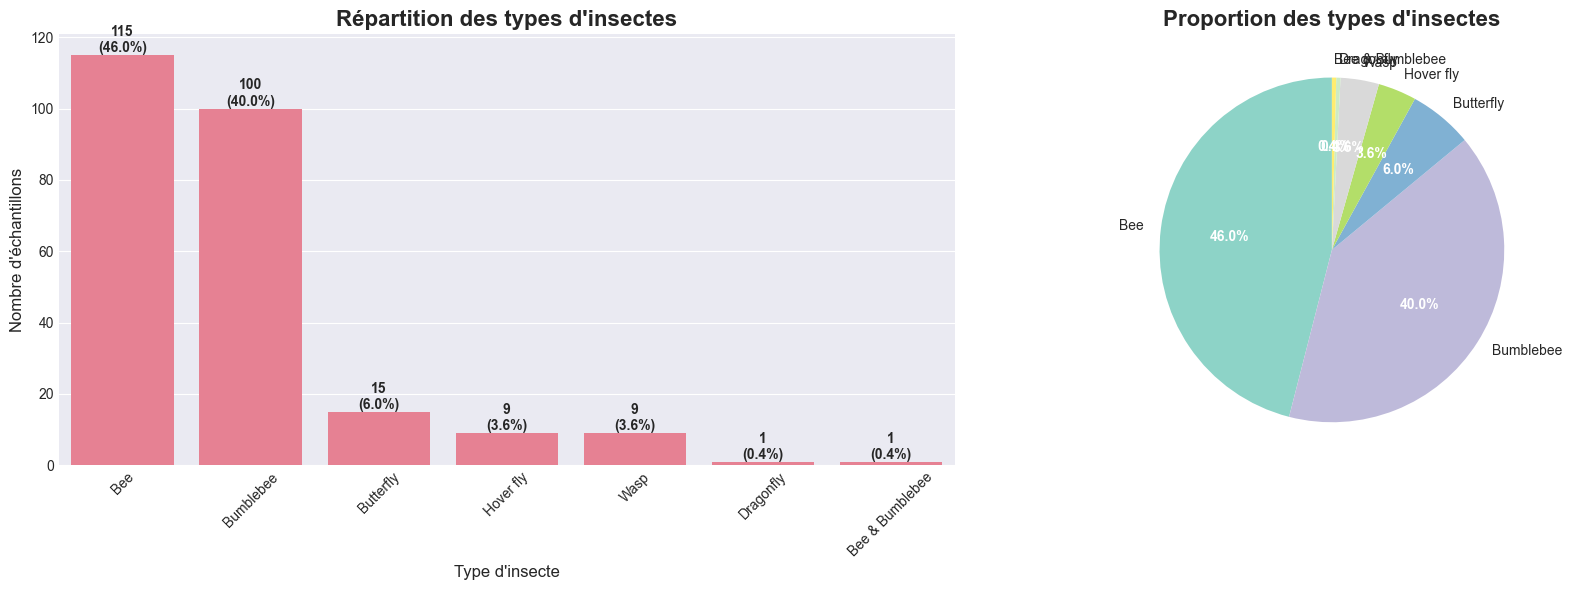


COMMENTAIRE - Répartition des classes:
- Déséquilibre important entre les classes : Bee (46%) et Bumblebee (40%) dominent largement
- Classes minoritaires : Butterfly (6%), Hover fly et Wasp (3.6% chacun)
- Classes très rares : Dragonfly et "Bee & Bumblebee" (0.4% chacun)
→ Ce déséquilibre pourrait affecter les performances des modèles de ML



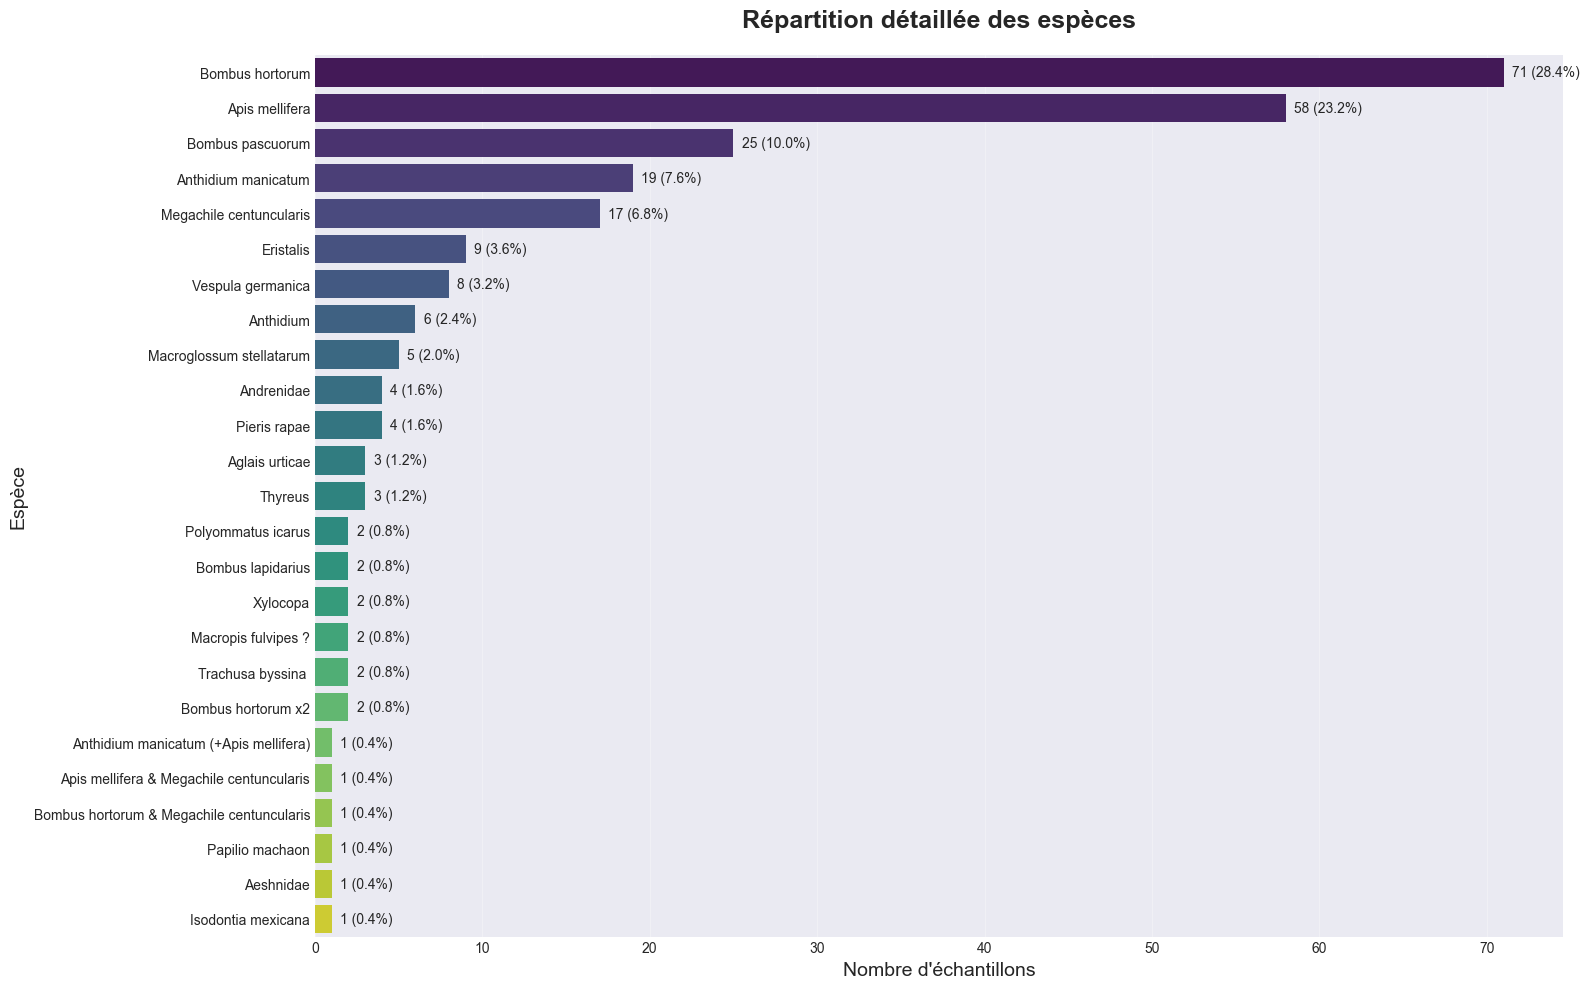


2. Analyse PCA...


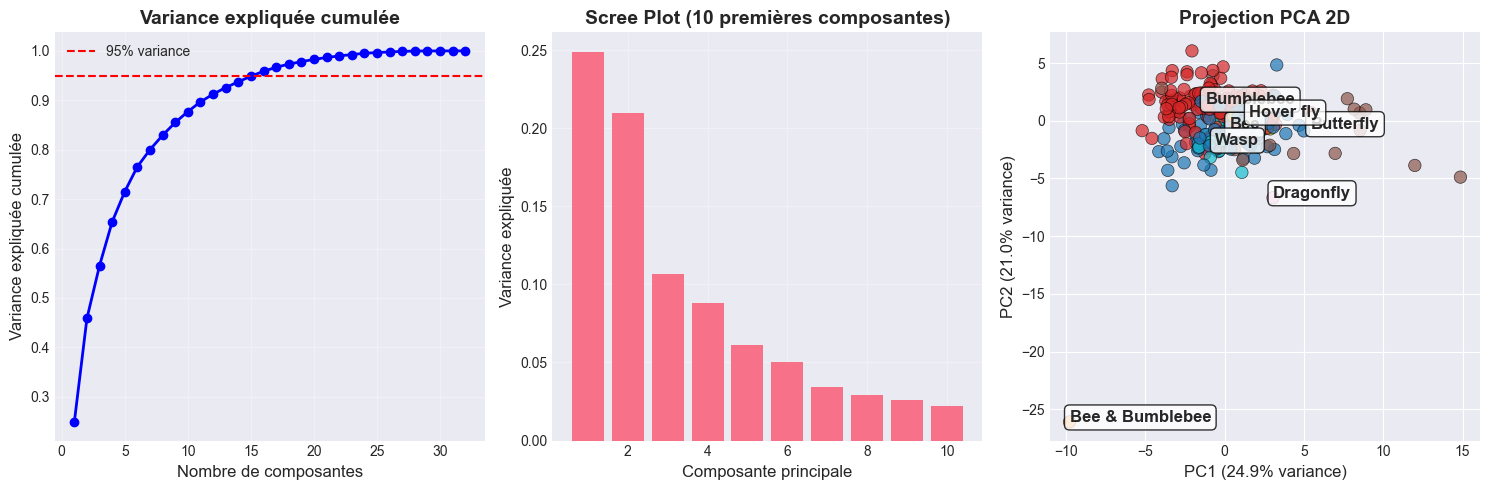


COMMENTAIRE - Analyse PCA:
- Les 2 premières composantes expliquent 45.9% de la variance
- Il faut 16 composantes pour expliquer 95% de la variance
- La projection montre un chevauchement entre Bee et Bumblebee, suggérant des caractéristiques similaires
- Les classes minoritaires (Butterfly, Dragonfly) semblent mieux séparées


3. Analyse des caractéristiques discriminantes...


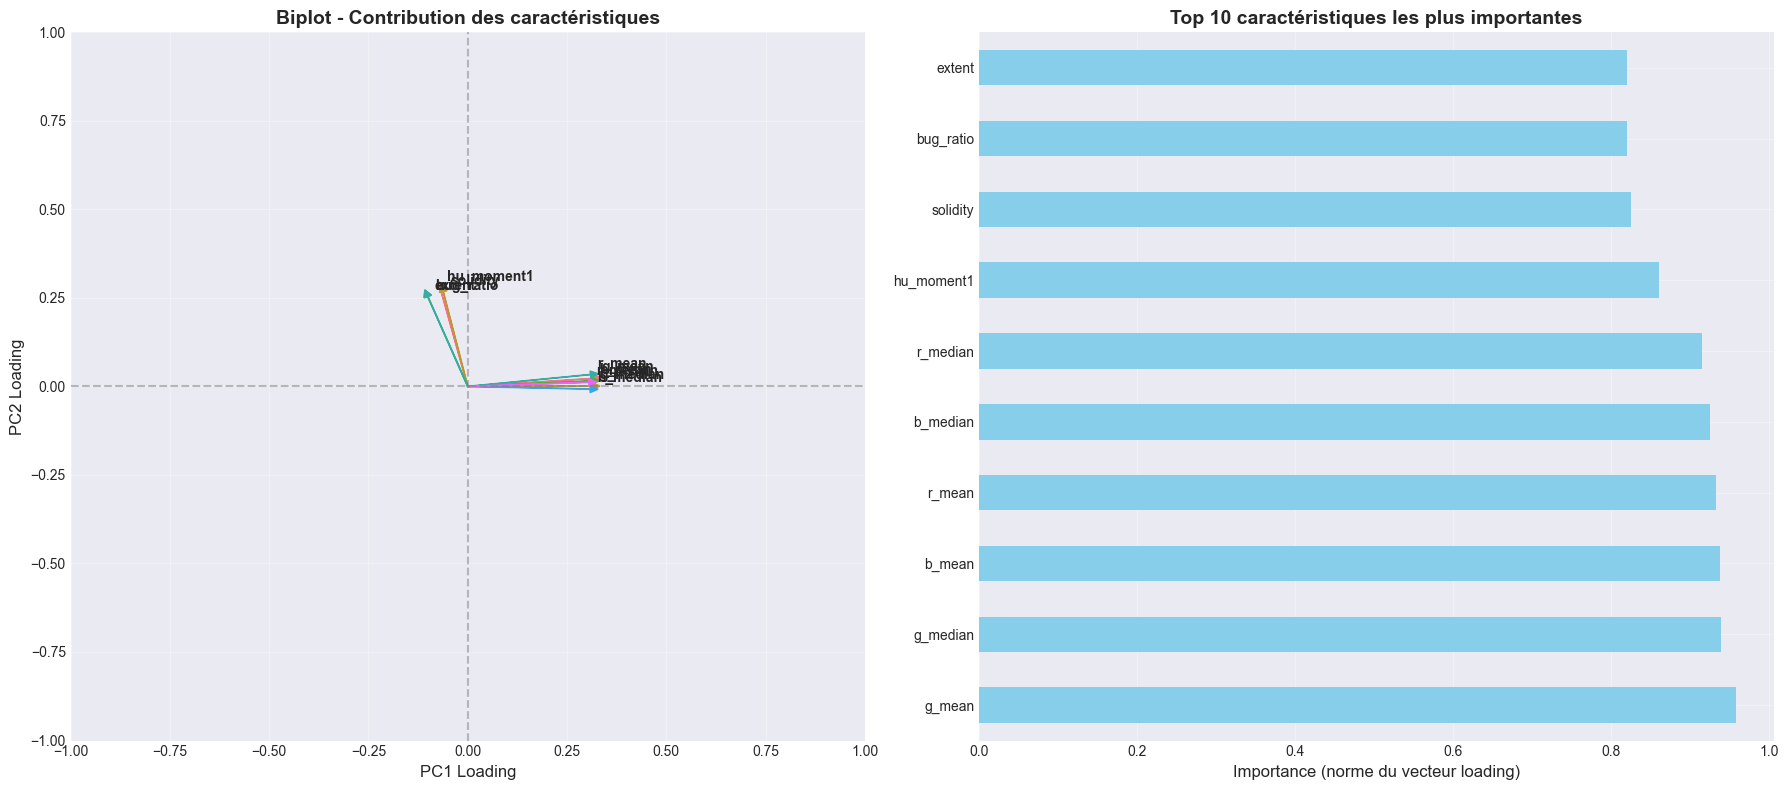


4. Calcul des projections non-linéaires...
Calcul t-SNE...
Calcul UMAP...
Calcul Isomap...


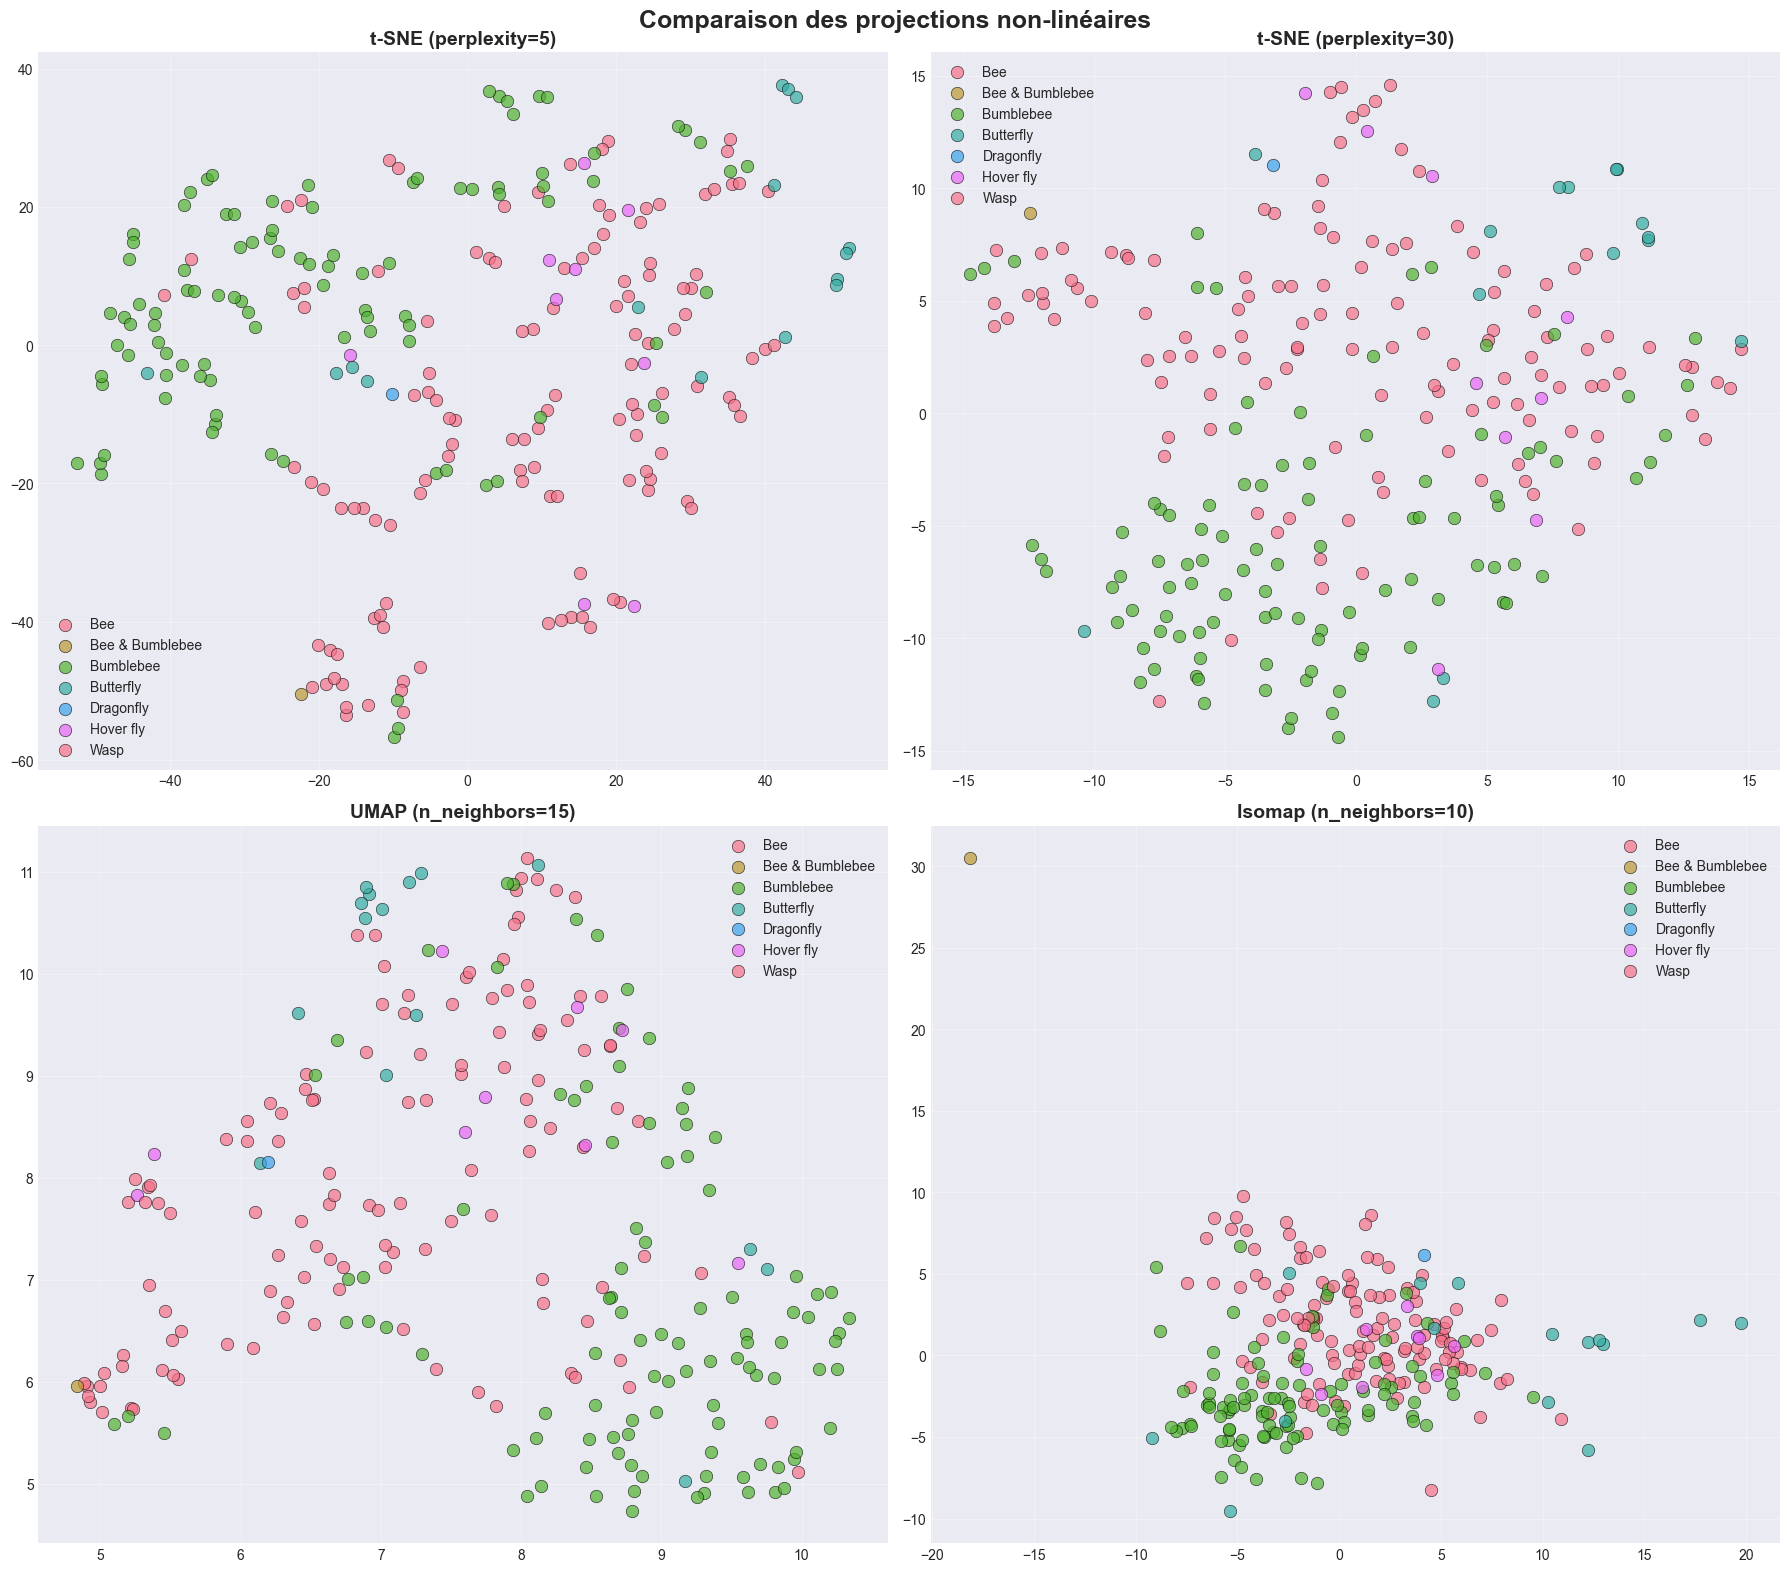


COMMENTAIRE - Projections non-linéaires:
- t-SNE (perplexity=5): Forme des clusters locaux très serrés, risque de sur-segmentation
- t-SNE (perplexity=30): Meilleure vue globale, Bee et Bumblebee forment un continuum
- UMAP: Excellente séparation des classes minoritaires (Butterfly, Dragonfly)
- Isomap: Préserve mieux la structure globale, montre la proximité Bee/Bumblebee
→ Les méthodes non-linéaires confirment la difficulté à séparer Bee et Bumblebee


5. Analyse détaillée des caractéristiques clés...


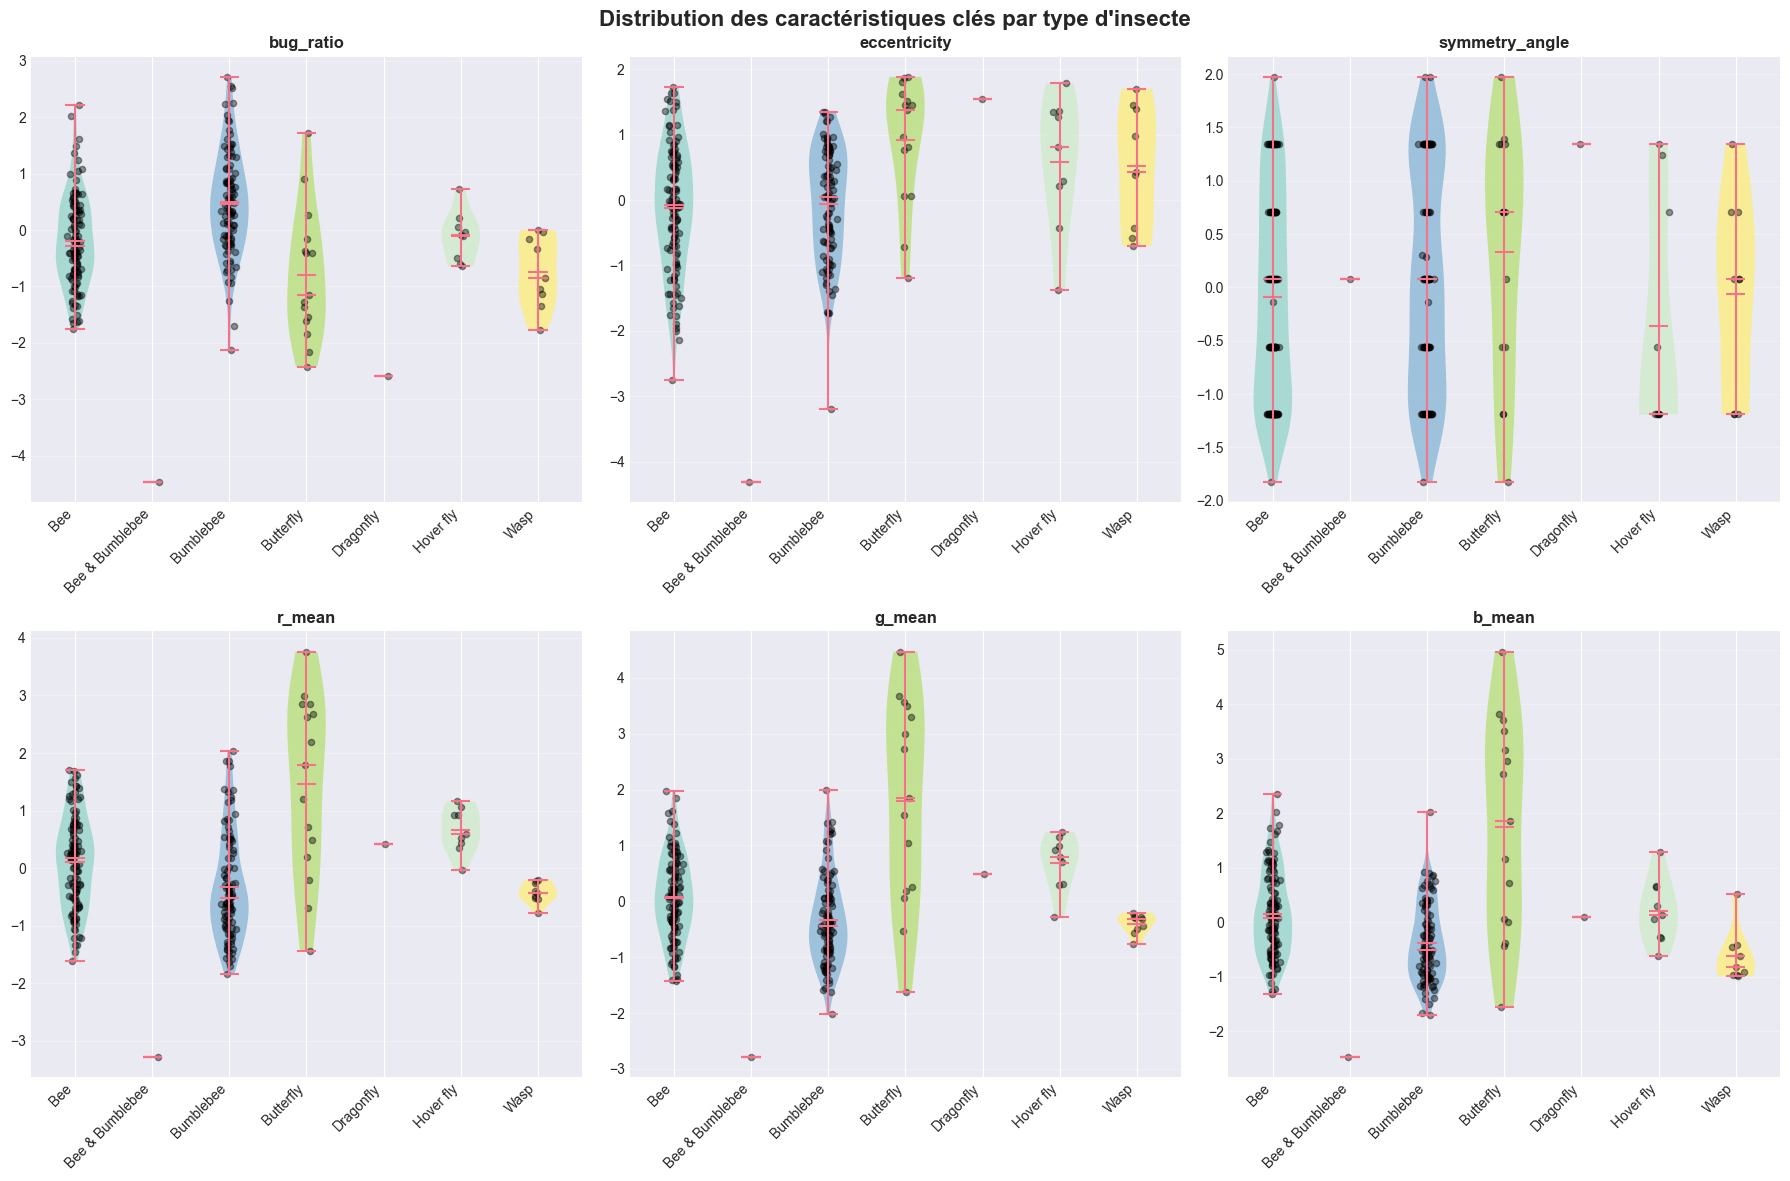


6. Analyse des corrélations...


<Figure size 2000x1600 with 0 Axes>

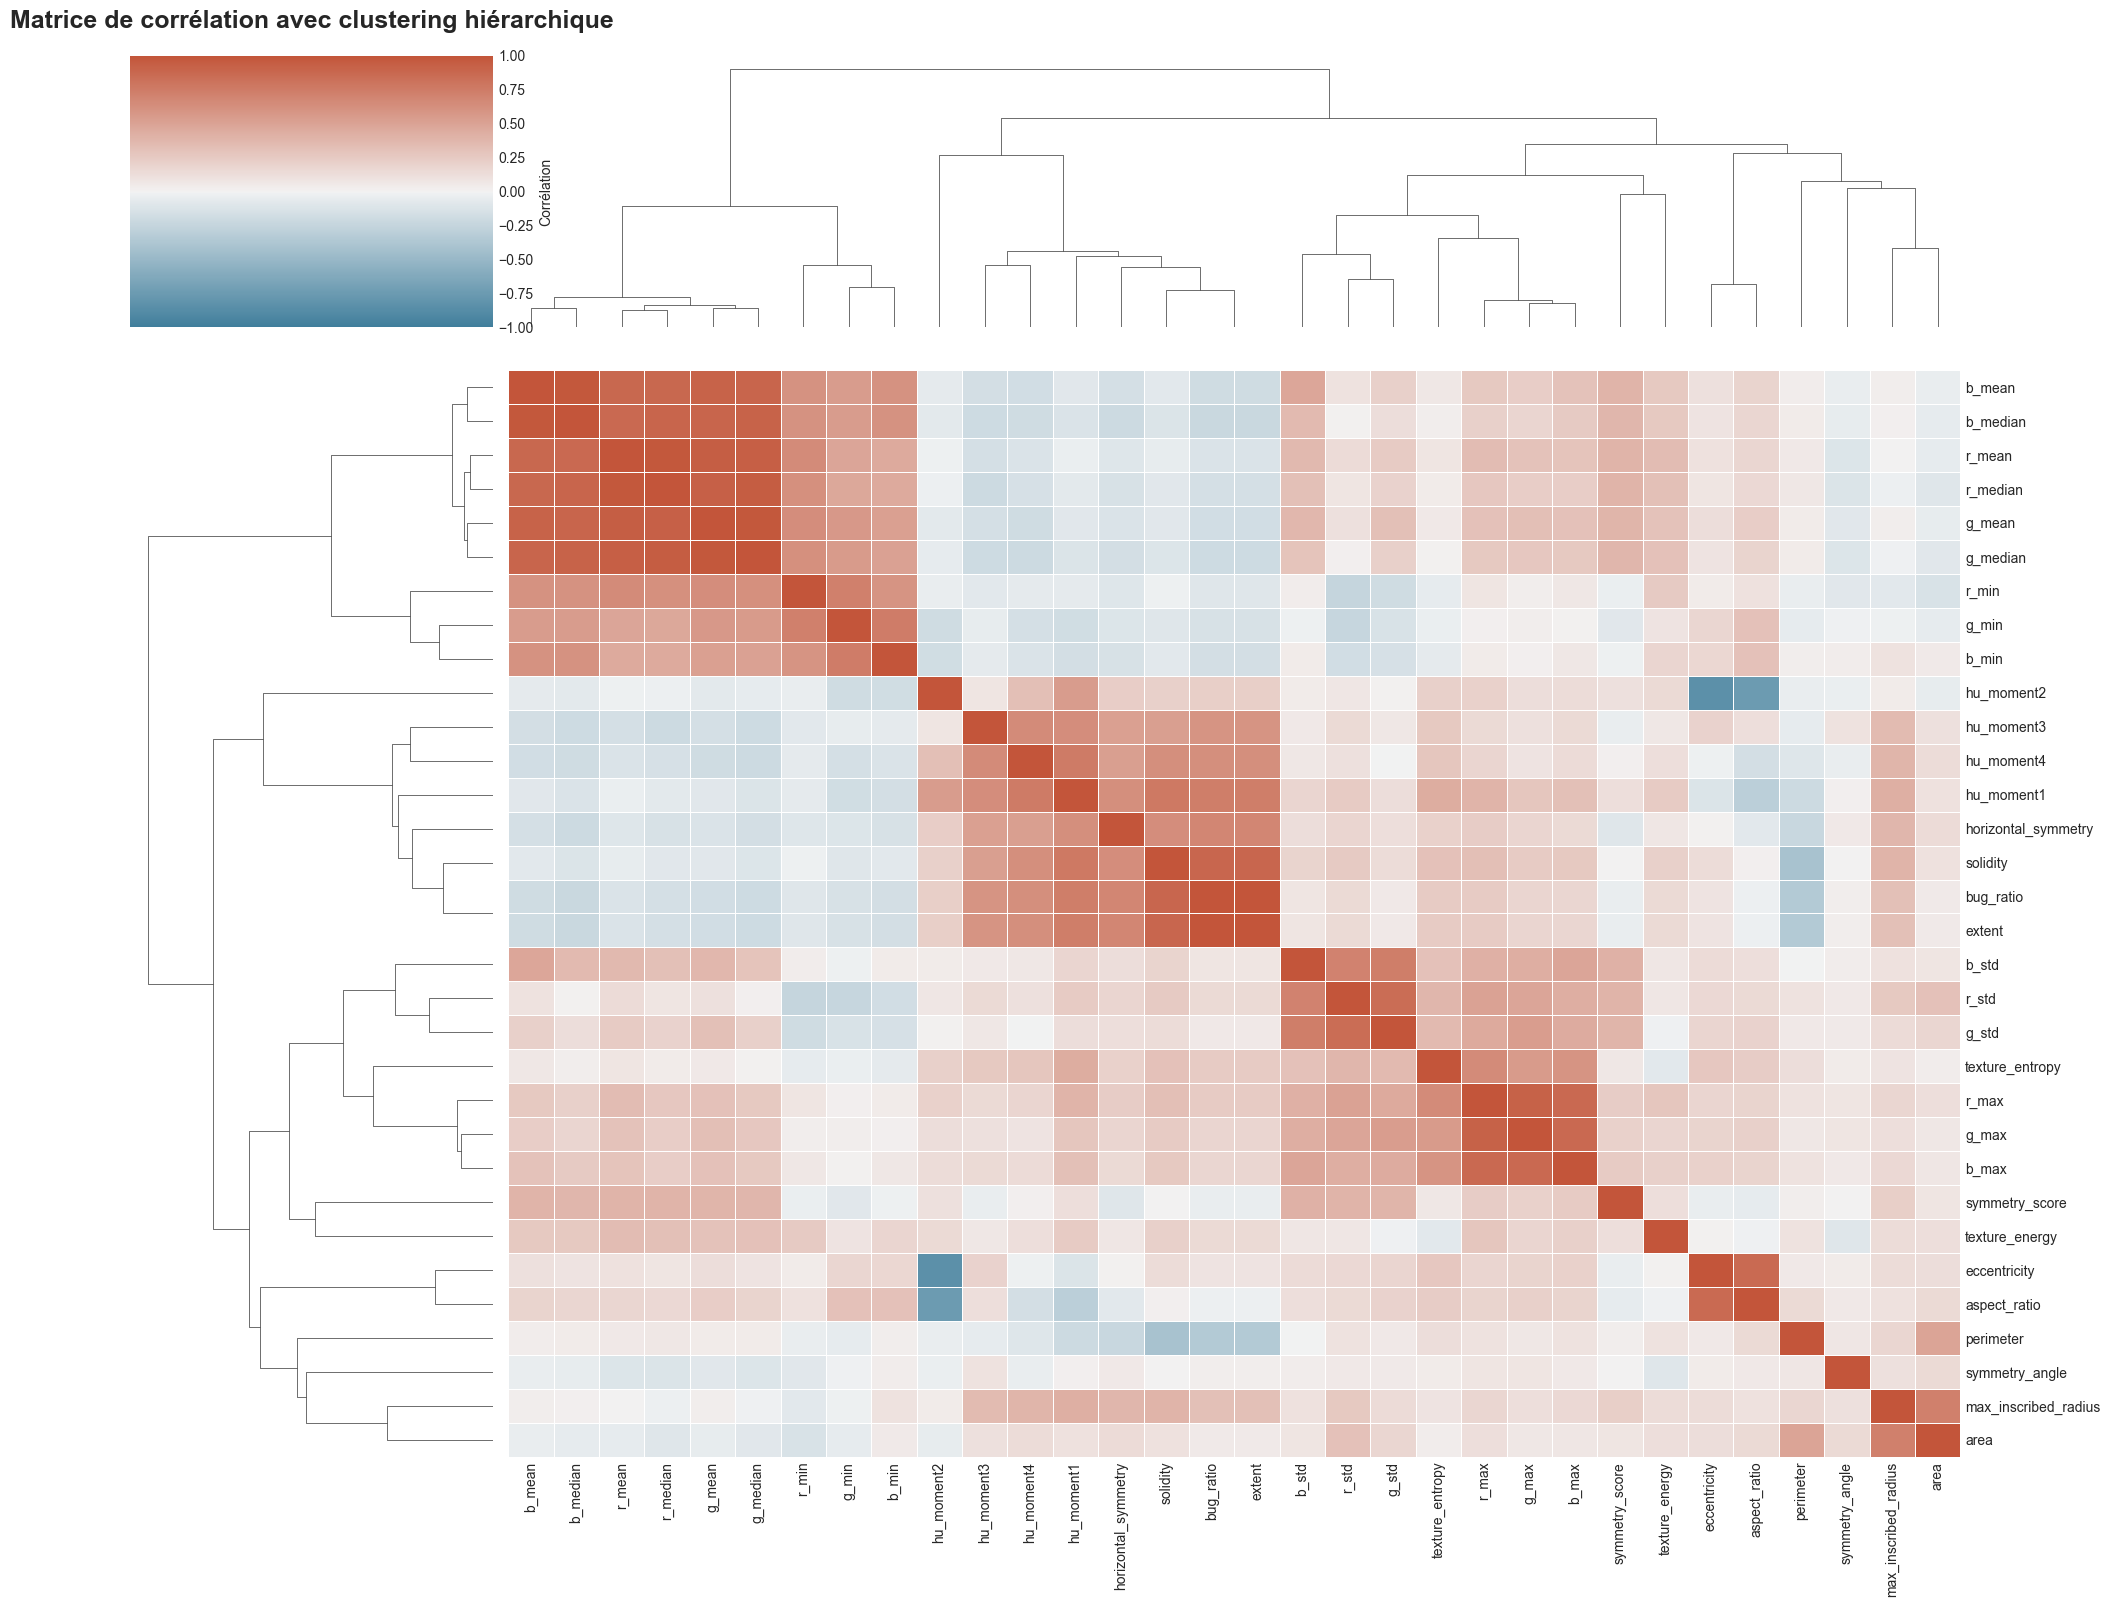


7. Création de la synthèse visuelle...


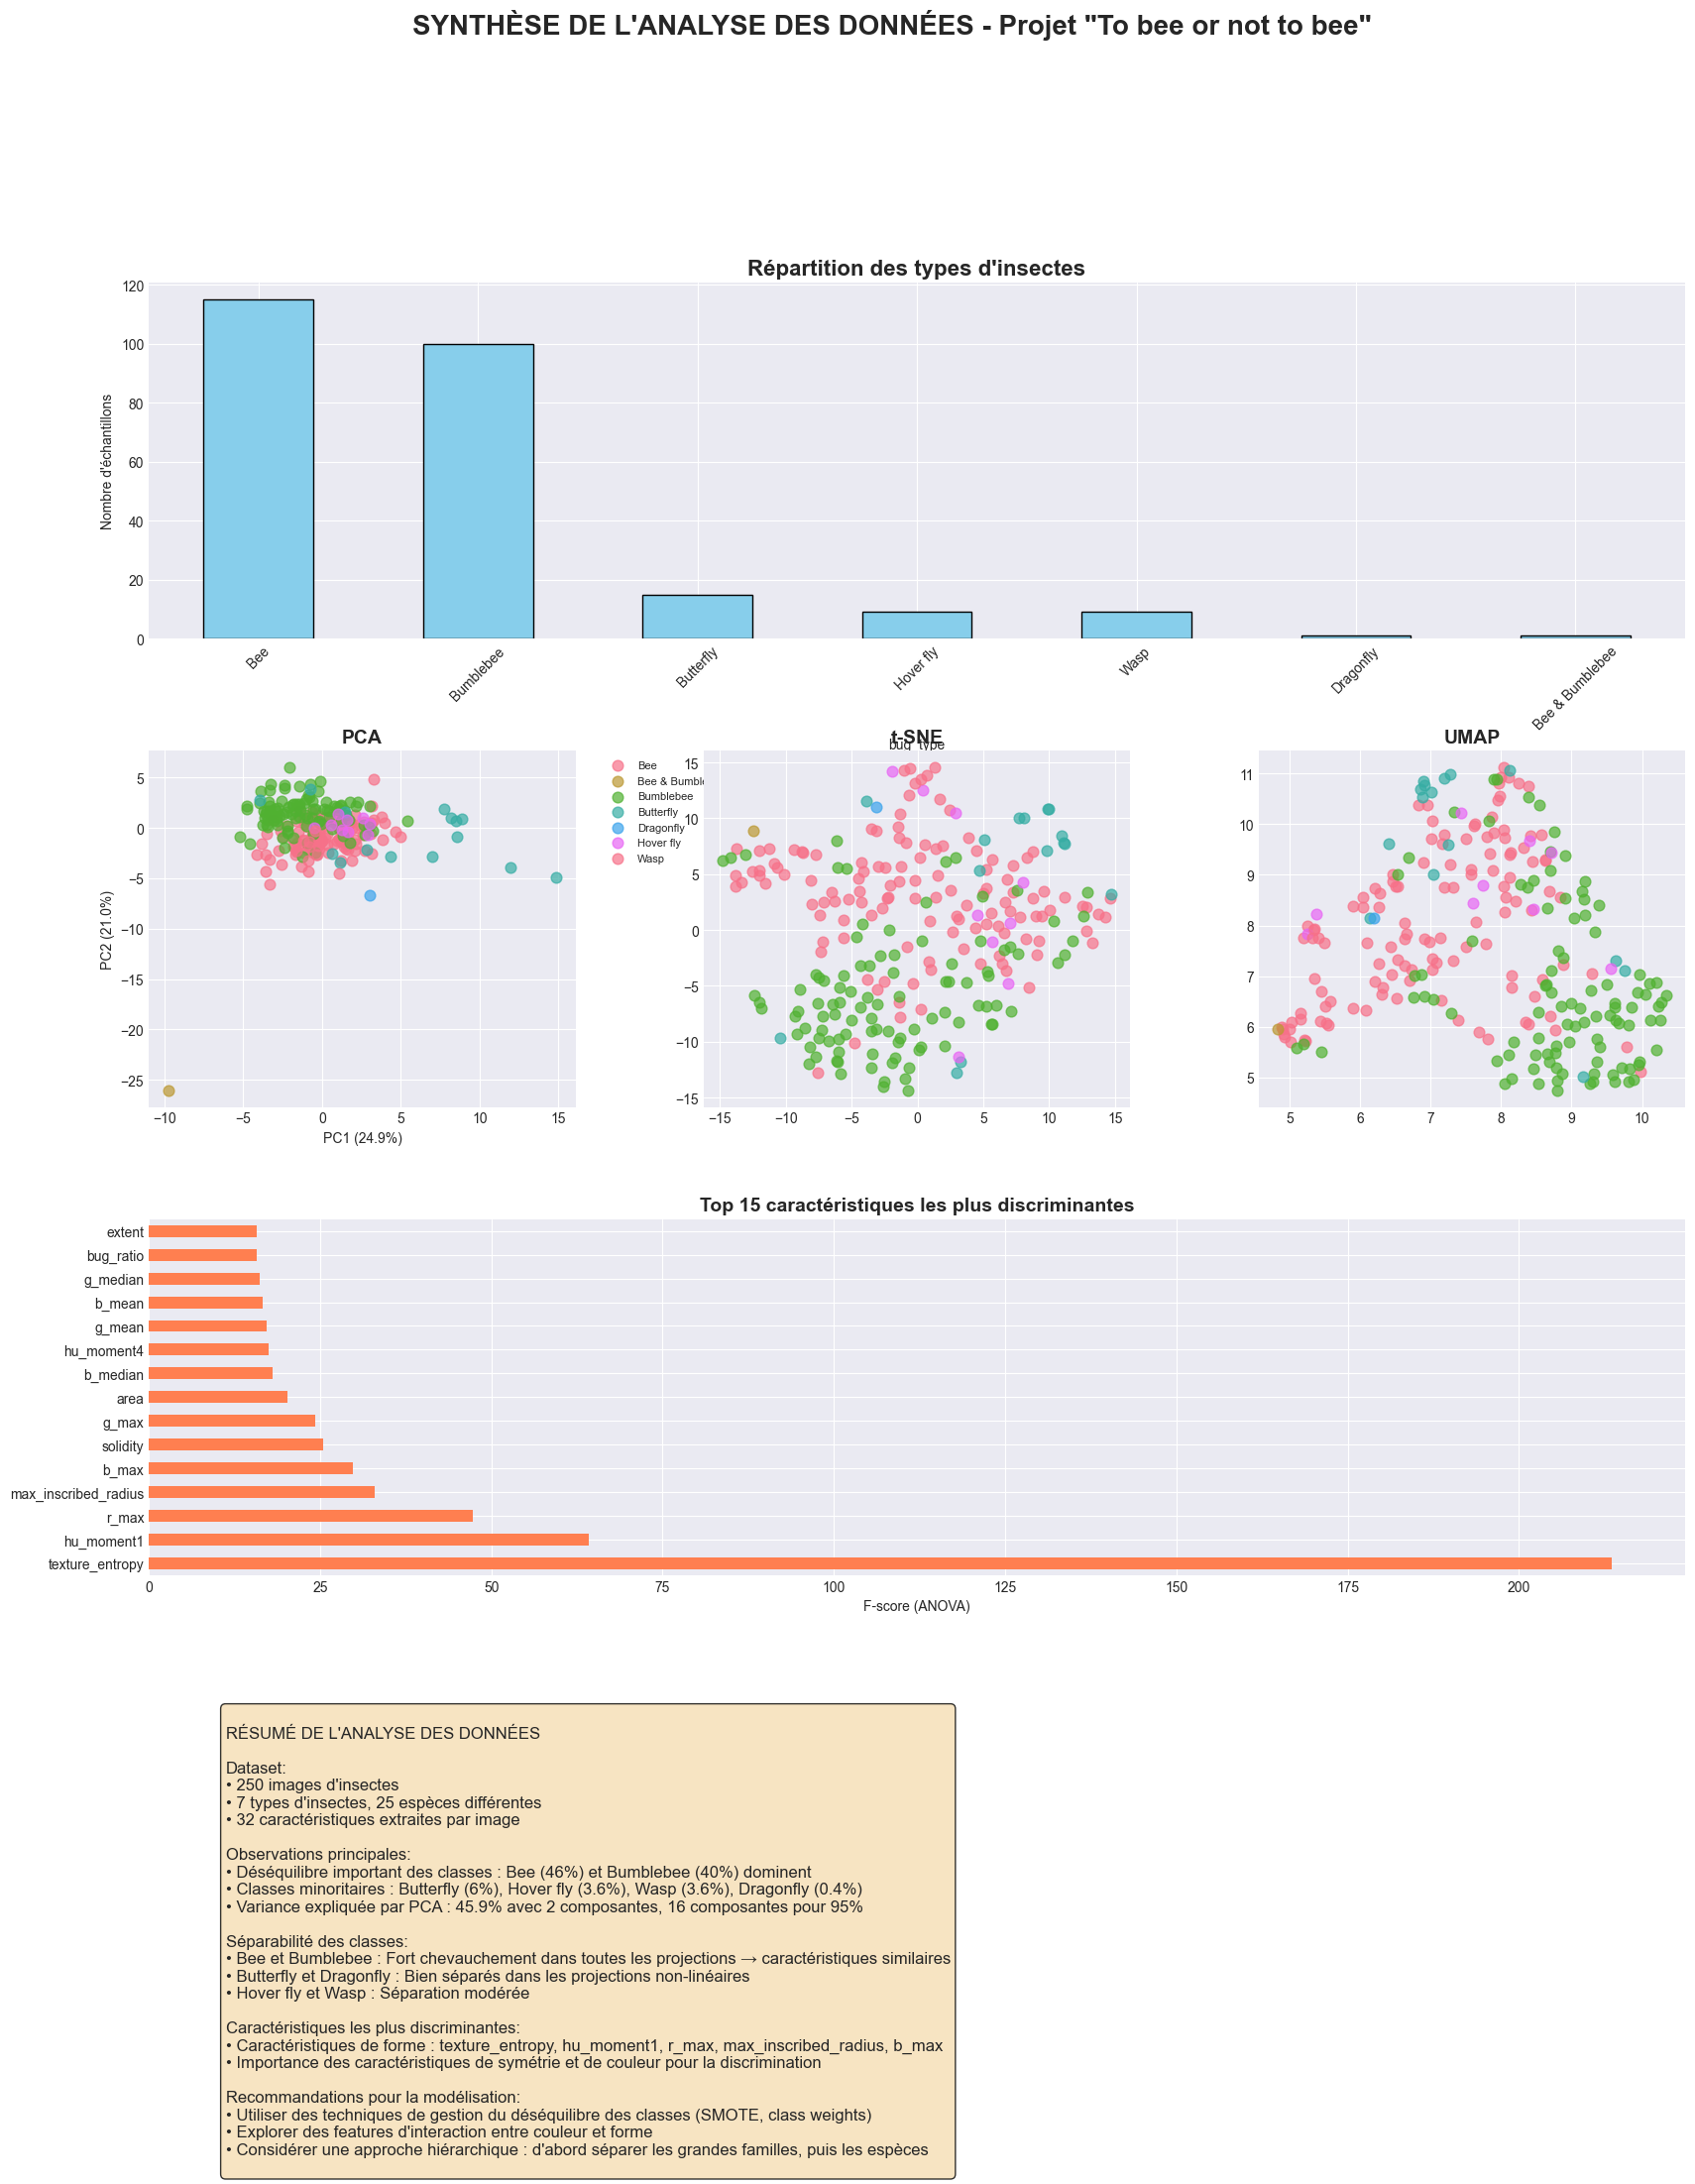


ANALYSE TERMINÉE AVEC SUCCÈS

Fichiers générés dans le dossier 'visualization/':
- bug_type_distribution_enhanced.png : Répartition améliorée des classes
- species_distribution_enhanced.png : Distribution détaillée des espèces
- pca_analysis_complete.png : Analyse PCA complète
- feature_importance_pca.png : Importance des caractéristiques
- nonlinear_projections_comparison.png : Comparaison des projections non-linéaires
- key_features_violin_plots.png : Distribution des caractéristiques clés
- correlation_matrix_clustered.png : Matrice de corrélation avec clustering
- data_analysis_synthesis.png : Synthèse complète de l'analyse

Ces visualisations répondent aux exigences du projet:
✓ Répartition des types d'insectes et espèces
✓ Projection PCA en 2D avec analyse de variance
✓ Projections non-linéaires (t-SNE, UMAP, Isomap)
✓ Commentaires significatifs pour chaque visualisation



In [21]:
# Data Visualization Améliorée pour "To bee or not to bee"
# Conforme aux consignes III.2 avec commentaires significatifs

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
import umap
import warnings
warnings.filterwarnings('ignore')

# Configuration du style global
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Créer le dossier de visualisation
os.makedirs('visualization', exist_ok=True)

# Charger les caractéristiques normalisées
features_df = pd.read_csv('features_normalized.csv')
print(f"Données chargées: {features_df.shape[0]} échantillons avec {features_df.shape[1]} caractéristiques")

# ==================== 1. RÉPARTITION DES CLASSES ====================
print("\n1. Analyse de la répartition des classes...")

# Créer une figure avec sous-graphiques pour une meilleure présentation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# 1.1 Répartition des types d'insectes (diagramme en barres + camembert)
bug_type_counts = features_df['bug_type'].value_counts()

# Diagramme en barres amélioré
sns.countplot(data=features_df, x='bug_type', ax=ax1, order=bug_type_counts.index)
ax1.set_title('Répartition des types d\'insectes', fontsize=16, fontweight='bold')
ax1.set_xlabel('Type d\'insecte', fontsize=12)
ax1.set_ylabel('Nombre d\'échantillons', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Ajouter les valeurs et pourcentages sur les barres
total = len(features_df)
for i, p in enumerate(ax1.patches):
    height = p.get_height()
    percentage = 100 * height / total
    ax1.annotate(f'{int(height)}\n({percentage:.1f}%)', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# 1.2 Diagramme circulaire pour une vue d'ensemble
colors = plt.cm.Set3(np.linspace(0, 1, len(bug_type_counts)))
wedges, texts, autotexts = ax2.pie(bug_type_counts.values, 
                                    labels=bug_type_counts.index, 
                                    autopct='%1.1f%%',
                                    colors=colors,
                                    startangle=90)
ax2.set_title('Proportion des types d\'insectes', fontsize=16, fontweight='bold')

# Améliorer la lisibilité
for text in texts:
    text.set_fontsize(10)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

plt.tight_layout()
plt.savefig('visualization/bug_type_distribution_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()

# COMMENTAIRE pour le rapport
print("""
COMMENTAIRE - Répartition des classes:
- Déséquilibre important entre les classes : Bee (46%) et Bumblebee (40%) dominent largement
- Classes minoritaires : Butterfly (6%), Hover fly et Wasp (3.6% chacun)
- Classes très rares : Dragonfly et "Bee & Bumblebee" (0.4% chacun)
→ Ce déséquilibre pourrait affecter les performances des modèles de ML
""")

# 1.3 Répartition détaillée des espèces
plt.figure(figsize=(16, 10))
species_counts = features_df['species'].value_counts()

# Créer un graphique horizontal pour mieux afficher les noms d'espèces
ax = sns.countplot(data=features_df, y='species', 
                   order=species_counts.index,
                   palette='viridis')

# Personnaliser l'apparence
ax.set_title('Répartition détaillée des espèces', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Nombre d\'échantillons', fontsize=14)
ax.set_ylabel('Espèce', fontsize=14)

# Ajouter les valeurs avec pourcentage
total = len(features_df)
for i, p in enumerate(ax.patches):
    width = p.get_width()
    percentage = 100 * width / total
    ax.annotate(f'{int(width)} ({percentage:.1f}%)', 
                (width + 0.5, p.get_y() + p.get_height() / 2), 
                ha='left', va='center', fontsize=10)

# Ajouter une grille pour faciliter la lecture
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('visualization/species_distribution_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================== 2. PCA - ANALYSE EN COMPOSANTES PRINCIPALES ====================
print("\n2. Analyse PCA...")

# Préparer les données
numeric_cols = [col for col in features_df.columns if col not in ['image_id', 'bug_type', 'species']]
X = features_df[numeric_cols].values
y = features_df['bug_type'].values
species = features_df['species'].values

# Appliquer PCA
pca = PCA()
X_pca_all = pca.fit_transform(X)

# Analyse de la variance expliquée
plt.figure(figsize=(15, 5))

# 2.1 Variance expliquée cumulée
plt.subplot(1, 3, 1)
cumsum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumsum_var) + 1), cumsum_var, 'bo-', linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.xlabel('Nombre de composantes', fontsize=12)
plt.ylabel('Variance expliquée cumulée', fontsize=12)
plt.title('Variance expliquée cumulée', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 2.2 Scree plot
plt.subplot(1, 3, 2)
plt.bar(range(1, 11), pca.explained_variance_ratio_[:10])
plt.xlabel('Composante principale', fontsize=12)
plt.ylabel('Variance expliquée', fontsize=12)
plt.title('Scree Plot (10 premières composantes)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# 2.3 Projection PCA 2D
plt.subplot(1, 3, 3)
pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X)

# Créer un mapping de couleurs cohérent
unique_types = np.unique(y)
color_map = {bug_type: i for i, bug_type in enumerate(unique_types)}
colors = [color_map[bug_type] for bug_type in y]

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=colors, cmap='tab10', 
                     alpha=0.7, s=80, edgecolors='black', linewidth=0.5)

# Ajouter les centroïdes de chaque classe
for bug_type in unique_types:
    mask = y == bug_type
    if np.sum(mask) > 0:
        centroid = X_pca[mask].mean(axis=0)
        plt.annotate(bug_type, centroid, 
                    fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title('Projection PCA 2D', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('visualization/pca_analysis_complete.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"""
COMMENTAIRE - Analyse PCA:
- Les 2 premières composantes expliquent {pca_2d.explained_variance_ratio_.sum():.1%} de la variance
- Il faut {np.argmax(cumsum_var >= 0.95) + 1} composantes pour expliquer 95% de la variance
- La projection montre un chevauchement entre Bee et Bumblebee, suggérant des caractéristiques similaires
- Les classes minoritaires (Butterfly, Dragonfly) semblent mieux séparées
""")

# ==================== 3. VISUALISATION DES CARACTÉRISTIQUES LES PLUS DISCRIMINANTES ====================
print("\n3. Analyse des caractéristiques discriminantes...")

# Identifier les features les plus importantes via PCA
loadings = pca_2d.components_.T * np.sqrt(pca_2d.explained_variance_)
loading_matrix = pd.DataFrame(
    loadings,
    columns=['PC1', 'PC2'],
    index=numeric_cols
)

# Calculer l'importance totale
loading_matrix['importance'] = np.sqrt(loading_matrix['PC1']**2 + loading_matrix['PC2']**2)
top_features = loading_matrix.nlargest(10, 'importance')

# Visualiser
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# 3.1 Biplot des loadings
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(0, color='gray', linestyle='--', alpha=0.5)

# Dessiner les vecteurs pour les top features
for idx, (feature, row) in enumerate(top_features.iterrows()):
    ax1.arrow(0, 0, row['PC1']/3, row['PC2']/3, 
              head_width=0.02, head_length=0.02, 
              fc=f'C{idx}', ec=f'C{idx}')
    ax1.annotate(feature, (row['PC1']/3, row['PC2']/3), 
                xytext=(5, 5), textcoords='offset points',
                fontsize=10, fontweight='bold')

ax1.set_xlabel('PC1 Loading', fontsize=12)
ax1.set_ylabel('PC2 Loading', fontsize=12)
ax1.set_title('Biplot - Contribution des caractéristiques', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 3.2 Importance des features
top_features['importance'].plot(kind='barh', ax=ax2, color='skyblue')
ax2.set_xlabel('Importance (norme du vecteur loading)', fontsize=12)
ax2.set_title('Top 10 caractéristiques les plus importantes', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('visualization/feature_importance_pca.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================== 4. PROJECTIONS NON-LINÉAIRES ====================
print("\n4. Calcul des projections non-linéaires...")

# Créer une grande figure pour comparer toutes les projections
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# 4.1 t-SNE avec différentes perplexités
print("Calcul t-SNE...")
perplexities = [5, 30]
for i, perp in enumerate(perplexities):
    ax = axes[0, i]
    tsne = TSNE(n_components=2, random_state=42, perplexity=perp)
    X_tsne = tsne.fit_transform(X)
    
    for bug_type in unique_types:
        mask = y == bug_type
        ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                  label=bug_type, alpha=0.7, s=80, edgecolors='black', linewidth=0.5)
    
    ax.set_title(f't-SNE (perplexity={perp})', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)

# 4.2 UMAP
print("Calcul UMAP...")
ax = axes[1, 0]
reducer = umap.UMAP(random_state=42, n_neighbors=15)
X_umap = reducer.fit_transform(X)

for bug_type in unique_types:
    mask = y == bug_type
    ax.scatter(X_umap[mask, 0], X_umap[mask, 1], 
              label=bug_type, alpha=0.7, s=80, edgecolors='black', linewidth=0.5)

ax.set_title('UMAP (n_neighbors=15)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

# 4.3 Isomap
print("Calcul Isomap...")
ax = axes[1, 1]
isomap = Isomap(n_components=2, n_neighbors=10)
X_isomap = isomap.fit_transform(X)

for bug_type in unique_types:
    mask = y == bug_type
    ax.scatter(X_isomap[mask, 0], X_isomap[mask, 1], 
              label=bug_type, alpha=0.7, s=80, edgecolors='black', linewidth=0.5)

ax.set_title('Isomap (n_neighbors=10)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.suptitle('Comparaison des projections non-linéaires', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig('visualization/nonlinear_projections_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("""
COMMENTAIRE - Projections non-linéaires:
- t-SNE (perplexity=5): Forme des clusters locaux très serrés, risque de sur-segmentation
- t-SNE (perplexity=30): Meilleure vue globale, Bee et Bumblebee forment un continuum
- UMAP: Excellente séparation des classes minoritaires (Butterfly, Dragonfly)
- Isomap: Préserve mieux la structure globale, montre la proximité Bee/Bumblebee
→ Les méthodes non-linéaires confirment la difficulté à séparer Bee et Bumblebee
""")

# ==================== 5. ANALYSE APPROFONDIE PAR CARACTÉRISTIQUE ====================
print("\n5. Analyse détaillée des caractéristiques clés...")

# Sélectionner les caractéristiques les plus discriminantes
key_features = ['bug_ratio', 'eccentricity', 'symmetry_angle', 'r_mean', 'g_mean', 'b_mean']

# Créer une matrice de violin plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(key_features):
    ax = axes[i]
    
    # Violin plot avec points individuels
    parts = ax.violinplot([features_df[features_df['bug_type'] == bt][feature].values 
                          for bt in unique_types], 
                         positions=range(len(unique_types)),
                         showmeans=True, showmedians=True)
    
    # Personnaliser les couleurs
    for pc, color in zip(parts['bodies'], plt.cm.Set3(np.linspace(0, 1, len(unique_types)))):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
    
    # Ajouter les points individuels
    for j, bug_type in enumerate(unique_types):
        y_data = features_df[features_df['bug_type'] == bug_type][feature].values
        x_data = np.random.normal(j, 0.04, size=len(y_data))
        ax.scatter(x_data, y_data, alpha=0.4, s=20, color='black')
    
    ax.set_xticks(range(len(unique_types)))
    ax.set_xticklabels(unique_types, rotation=45, ha='right')
    ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Distribution des caractéristiques clés par type d\'insecte', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('visualization/key_features_violin_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================== 6. MATRICE DE CORRÉLATION AMÉLIORÉE ====================
print("\n6. Analyse des corrélations...")

# Calculer la matrice de corrélation
correlation_matrix = features_df[numeric_cols].corr()

# Créer un masque pour le triangle supérieur
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Visualisation améliorée
plt.figure(figsize=(20, 16))

# Utiliser une palette divergente
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Heatmap avec dendrogramme
sns.clustermap(correlation_matrix, 
               mask=None,  # Pas de masque pour le clustermap
               cmap=cmap, 
               vmin=-1, vmax=1,
               center=0,
               square=True,
               linewidths=0.5,
               cbar_kws={"shrink": 0.8, "label": "Corrélation"},
               figsize=(20, 16))

plt.title('Matrice de corrélation avec clustering hiérarchique', fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('visualization/correlation_matrix_clustered.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================== 7. SYNTHÈSE FINALE ====================
print("\n7. Création de la synthèse visuelle...")

# Créer une figure de synthèse
fig = plt.figure(figsize=(20, 24))

# Définir la grille
gs = fig.add_gridspec(4, 3, height_ratios=[1, 1, 1, 1.2], hspace=0.3, wspace=0.3)

# 7.1 Répartition des classes
ax1 = fig.add_subplot(gs[0, :])
features_df['bug_type'].value_counts().plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Répartition des types d\'insectes', fontsize=16, fontweight='bold')
ax1.set_ylabel('Nombre d\'échantillons')
ax1.tick_params(axis='x', rotation=45)

# 7.2 PCA
ax2 = fig.add_subplot(gs[1, 0])
for bug_type in unique_types:
    mask = y == bug_type
    ax2.scatter(X_pca[mask, 0], X_pca[mask, 1], label=bug_type, alpha=0.7, s=60)
ax2.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})')
ax2.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})')
ax2.set_title('PCA', fontsize=14, fontweight='bold')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# 7.3 t-SNE
ax3 = fig.add_subplot(gs[1, 1])
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)
for bug_type in unique_types:
    mask = y == bug_type
    ax3.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=bug_type, alpha=0.7, s=60)
ax3.set_title('t-SNE', fontsize=14, fontweight='bold')

# 7.4 UMAP
ax4 = fig.add_subplot(gs[1, 2])
for bug_type in unique_types:
    mask = y == bug_type
    ax4.scatter(X_umap[mask, 0], X_umap[mask, 1], label=bug_type, alpha=0.7, s=60)
ax4.set_title('UMAP', fontsize=14, fontweight='bold')

# 7.5 Features importantes
ax5 = fig.add_subplot(gs[2, :])
feature_importance_df = pd.DataFrame()
for feature in numeric_cols:
    # Calculer l'ANOVA F-score comme mesure d'importance
    from sklearn.feature_selection import f_classif
    f_score, _ = f_classif(features_df[[feature]].values, y)
    feature_importance_df.loc[feature, 'F-score'] = f_score[0]

top_15_features = feature_importance_df.nlargest(15, 'F-score')
top_15_features.plot(kind='barh', ax=ax5, color='coral', legend=False)
ax5.set_xlabel('F-score (ANOVA)')
ax5.set_title('Top 15 caractéristiques les plus discriminantes', fontsize=14, fontweight='bold')

# 7.6 Résumé textuel
ax6 = fig.add_subplot(gs[3, :])
ax6.axis('off')

summary_text = f"""
RÉSUMÉ DE L'ANALYSE DES DONNÉES

Dataset:
• {len(features_df)} images d'insectes
• {len(unique_types)} types d'insectes, {len(features_df['species'].unique())} espèces différentes
• {len(numeric_cols)} caractéristiques extraites par image

Observations principales:
• Déséquilibre important des classes : Bee (46%) et Bumblebee (40%) dominent
• Classes minoritaires : Butterfly (6%), Hover fly (3.6%), Wasp (3.6%), Dragonfly (0.4%)
• Variance expliquée par PCA : {pca_2d.explained_variance_ratio_.sum():.1%} avec 2 composantes, {np.argmax(cumsum_var >= 0.95) + 1} composantes pour 95%

Séparabilité des classes:
• Bee et Bumblebee : Fort chevauchement dans toutes les projections → caractéristiques similaires
• Butterfly et Dragonfly : Bien séparés dans les projections non-linéaires
• Hover fly et Wasp : Séparation modérée

Caractéristiques les plus discriminantes:
• Caractéristiques de forme : {', '.join(top_15_features.index[:5].tolist())}
• Importance des caractéristiques de symétrie et de couleur pour la discrimination

Recommandations pour la modélisation:
• Utiliser des techniques de gestion du déséquilibre des classes (SMOTE, class weights)
• Explorer des features d'interaction entre couleur et forme
• Considérer une approche hiérarchique : d'abord séparer les grandes familles, puis les espèces
"""

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, 
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.suptitle('SYNTHÈSE DE L\'ANALYSE DES DONNÉES - Projet "To bee or not to bee"', 
             fontsize=20, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('visualization/data_analysis_synthesis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("ANALYSE TERMINÉE AVEC SUCCÈS")
print("="*80)
print(f"""
Fichiers générés dans le dossier 'visualization/':
- bug_type_distribution_enhanced.png : Répartition améliorée des classes
- species_distribution_enhanced.png : Distribution détaillée des espèces
- pca_analysis_complete.png : Analyse PCA complète
- feature_importance_pca.png : Importance des caractéristiques
- nonlinear_projections_comparison.png : Comparaison des projections non-linéaires
- key_features_violin_plots.png : Distribution des caractéristiques clés
- correlation_matrix_clustered.png : Matrice de corrélation avec clustering
- data_analysis_synthesis.png : Synthèse complète de l'analyse

Ces visualisations répondent aux exigences du projet:
✓ Répartition des types d'insectes et espèces
✓ Projection PCA en 2D avec analyse de variance
✓ Projections non-linéaires (t-SNE, UMAP, Isomap)
✓ Commentaires significatifs pour chaque visualisation
""")

In [ ]:
# Script de prédiction pour les images de test (251-347)
# Projet "To bee or not to bee"

import os
import numpy as np
import pandas as pd
import joblib
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuration
TEST_IMAGES_START = 251
TEST_IMAGES_END = 347
TEST_DIR = "../test"  # Ajustez selon votre structure
OUTPUT_CSV = "predictions_test.csv"

def extract_test_features(image_id, test_dir):
    """
    Extraire les features pour une image de test
    Similaire à extract_all_features mais adapté pour le test set
    """
    try:
        # Charger l'image et le masque depuis le dossier test
        image_path = os.path.join(test_dir, "images", f"{image_id}.jpg")
        mask_path = os.path.join(test_dir, "masks", f"binary_{image_id}.tif")
        
        # Vérifier si les fichiers existent
        if not os.path.exists(image_path):
            print(f"Image {image_id} non trouvée")
            return create_default_features(image_id)
            
        if not os.path.exists(mask_path):
            print(f"Masque {image_id} non trouvé")
            return create_default_features(image_id)
        
        # Charger image et masque (sans visualisation pour le test)
        image, mask = load_image_and_mask(image_id, visualize=False)
        
        if image is None or mask is None:
            return create_default_features(image_id)
        
        # Extraire toutes les features
        shape_features = extract_shape_features(mask)
        bug_ratio = calculate_bug_ratio(mask)
        color_features = extract_color_features(image, mask)
        additional_features = extract_additional_features(image, mask)
        
        # Calculer le cercle inscrit
        max_radius, circle_center = compute_best_inscribed_circle(mask)
        
        # Calculer l'axe de symétrie si possible
        if max_radius > 5:
            symmetry_score, symmetry_angle = compute_best_symmetry_plane(
                image, mask, circle_center, max_radius
            )
        else:
            symmetry_score = 0.0
            symmetry_angle = 0.0
        
        # Combiner toutes les features
        features = {
            'image_id': int(image_id),
            'bug_ratio': bug_ratio,
            'max_inscribed_radius': max_radius,
            'symmetry_score': symmetry_score,
            'symmetry_angle': symmetry_angle,
            **shape_features,
            **color_features,
            **additional_features
        }
        
        return features
        
    except Exception as e:
        print(f"Erreur lors du traitement de l'image {image_id}: {e}")
        return create_default_features(image_id)

def main():
    """
    Pipeline principal pour générer les prédictions sur le test set
    """
    print("=== PRÉDICTION SUR LE TEST SET (251-347) ===")
    
    # 1. Charger le modèle et les objets sauvegardés
    print("\n1. Chargement du modèle...")
    try:
        best_model = joblib.load('best_model.pkl')
        scaler = joblib.load('scaler.pkl')
        label_encoder = joblib.load('label_encoder.pkl')
        print("✓ Modèle, scaler et label encoder chargés avec succès")
    except Exception as e:
        print(f"❌ Erreur lors du chargement: {e}")
        print("Assurez-vous d'avoir exécuté le script de ML et sauvegardé les modèles")
        return
    
    # 2. Extraire les features pour toutes les images de test
    print("\n2. Extraction des features du test set...")
    test_features = []
    
    for image_id in tqdm(range(TEST_IMAGES_START, TEST_IMAGES_END + 1), 
                        desc="Extraction des features"):
        features = extract_test_features(image_id, TEST_DIR)
        test_features.append(features)
    
    # Convertir en DataFrame
    test_df = pd.DataFrame(test_features)
    print(f"✓ Features extraites pour {len(test_df)} images")
    
    # 3. Préparer les données pour la prédiction
    print("\n3. Préparation des données...")
    
    # S'assurer que les colonnes sont dans le même ordre que l'entraînement
    # Charger les colonnes depuis le fichier d'entraînement pour référence
    train_features = pd.read_csv('features_normalized.csv')
    feature_cols = [col for col in train_features.columns 
                   if col not in ['image_id', 'bug_type', 'species']]
    
    # Vérifier que toutes les colonnes sont présentes
    missing_cols = set(feature_cols) - set(test_df.columns)
    if missing_cols:
        print(f"⚠️  Colonnes manquantes: {missing_cols}")
        # Ajouter les colonnes manquantes avec des valeurs par défaut
        for col in missing_cols:
            test_df[col] = 0.0
    
    # Sélectionner et ordonner les colonnes
    X_test = test_df[feature_cols].values
    
    # 4. Normaliser avec le même scaler que l'entraînement
    print("\n4. Normalisation des features...")
    X_test_normalized = scaler.transform(X_test)
    
    # 5. Faire les prédictions
    print("\n5. Génération des prédictions...")
    predictions_encoded = best_model.predict(X_test_normalized)
    
    # 6. Décoder les prédictions
    predictions = label_encoder.inverse_transform(predictions_encoded)
    
    # 7. Créer le DataFrame de sortie
    print("\n6. Création du fichier CSV de sortie...")
    output_df = pd.DataFrame({
        'ID': test_df['image_id'],
        'bug type': predictions
    })
    
    # Afficher un aperçu
    print("\nAperçu des prédictions:")
    print(output_df.head(10))
    
    # Afficher la distribution des prédictions
    print("\nDistribution des prédictions:")
    print(output_df['bug type'].value_counts())
    
    # 8. Sauvegarder le CSV
    output_df.to_csv(OUTPUT_CSV, index=False)
    print(f"\n✓ Prédictions sauvegardées dans '{OUTPUT_CSV}'")
    
    # 9. Vérifications finales
    print("\n=== VÉRIFICATIONS FINALES ===")
    print(f"Nombre d'images prédites: {len(output_df)}")
    print(f"IDs: {output_df['ID'].min()} à {output_df['ID'].max()}")
    print(f"Format du CSV: {output_df.shape[1]} colonnes ('ID' et 'bug type')")
    
    # Vérifier s'il y a des prédictions suspectes
    if 'Bee & Bumblebee' in output_df['bug type'].values:
        count = (output_df['bug type'] == 'Bee & Bumblebee').sum()
        print(f"\n⚠️  Attention: {count} images prédites comme 'Bee & Bumblebee'")
        print("Cela peut indiquer que le modèle a appris cette classe malgré un seul exemple")
    
    print("\n✅ PRÉDICTIONS TERMINÉES AVEC SUCCÈS!")
    print(f"Fichier à soumettre: {OUTPUT_CSV}")

if __name__ == "__main__":
    main()

# ==================== SCRIPT ALTERNATIF SANS RÉEXTRACTION ====================
# Si les features du test set sont déjà extraites dans un fichier CSV

def predict_from_existing_features(test_features_csv):
    """
    Faire des prédictions à partir de features déjà extraites
    """
    print("=== PRÉDICTION À PARTIR DE FEATURES EXISTANTES ===")
    
    # Charger les modèles
    best_model = joblib.load('best_model.pkl')
    scaler = joblib.load('scaler.pkl')
    label_encoder = joblib.load('label_encoder.pkl')
    
    # Charger les features de test
    test_df = pd.read_csv(test_features_csv)
    
    # Préparer les données
    train_features = pd.read_csv('features_normalized.csv')
    feature_cols = [col for col in train_features.columns 
                   if col not in ['image_id', 'bug_type', 'species']]
    
    X_test = test_df[feature_cols].values
    X_test_normalized = scaler.transform(X_test)
    
    # Prédictions
    predictions_encoded = best_model.predict(X_test_normalized)
    predictions = label_encoder.inverse_transform(predictions_encoded)
    
    # Créer le CSV de sortie
    output_df = pd.DataFrame({
        'ID': test_df['image_id'],
        'bug type': predictions
    })
    
    output_df.to_csv(OUTPUT_CSV, index=False)
    print(f"✓ Prédictions sauvegardées dans '{OUTPUT_CSV}'")
    
    return output_df

# ==================== CONSEILS POUR LA SOUMISSION ====================
"""
CHECKLIST AVANT SOUMISSION:

1. ✓ Le fichier CSV contient exactement 2 colonnes: 'ID' et 'bug type'
2. ✓ Les IDs vont de 251 à 347 (97 images)
3. ✓ Les valeurs de 'bug type' sont parmi: 
   ['Bee', 'Bumblebee', 'Butterfly', 'Dragonfly', 'Hover fly', 'Wasp']
4. ✓ Pas de valeurs manquantes
5. ✓ Format CSV correct (virgule comme séparateur)

AMÉLIORATION DES PERFORMANCES:

Si vos résultats ne sont pas satisfaisants, considérez:
1. Ensemble de modèles (voter entre plusieurs classifieurs)
2. Augmentation des données d'entraînement (rotations, flips)
3. Feature engineering supplémentaire
4. Ajustement des hyperparamètres
5. Gestion du déséquilibre des classes (class_weight='balanced')

GESTION DES CAS DIFFICILES:

- Si une image n'a pas de masque: utiliser les features par défaut
- Si l'extraction échoue: prédire la classe majoritaire (Bee ou Bumblebee)
- Pour les classes rares (Dragonfly): vérifier manuellement si possible
"""